In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"
os.environ["TF_FORCE_GPU_ALLOW_GROWTH"]="true"

import numpy as np
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm

import tensorflow as tf

import pixiedust
from functools import partial
import gin
import itertools
import multiprocessing
import pickle

from synthetic_data import xs_e, ys_e, Q1, xs, ys, A

# Import dependencies
import plotly
import plotly.graph_objs as go

# Configure Plotly to be rendered inline in the notebook.
plotly.offline.init_notebook_mode()

import seaborn as sns

Pixiedust database opened successfully


In [2]:
# hyperparameters setup
common = {
    'build_decoder_model.init_fp_dist': None,
    'build_feature_model.init_fp_dist': None,
    'build_reconstructor_model.init_fp_dist': None,
    'step.l_rec_coeff': 5,
    'get_results.epochs': 1000,
    'get_results.batch_size': 64,
    'step.optimizer': tf.keras.optimizers.Adam(lr=0.001),
    'get_results.step': 'step',
    'mask_step.mask': None,
    'step.l1_coeff': 0.0,
    'projection_step.l1_ball_size': None
}

sweep_00 = {
    'step.l_rec_coeff': [1, 10],
    'get_results.batch_size': [128],
    'repetitions': range(2),
    'name': ['sweep-00'],
    '_meta': [{'param_1': 'step.l_rec_coeff',
              'param_2': 'get_results.batch_size'}],
}

sweep_01 = {
    'step.l_rec_coeff': np.logspace(-2, 2, 10),
    'get_results.batch_size': [64, 128, 256, 512],
    'repetitions': range(5),
    'name': ['sweep-01'],
    '_meta': [{'param_1': 'step.l_rec_coeff',
              'param_2': 'get_results.batch_size'}],
}

sweep_02 = {
    'step.l1_coeff': np.logspace(-5, 2, 10),
    'step.l_rec_coeff': np.logspace(0, 1, 3),
    'get_results.batch_size': [128],
    'repetitions': range(5),
    'name': ['sweep-02'],
    '_meta': [{'param_1': 'step.l_rec_coeff',
              'param_2': 'step.l1_coeff'}],
}

sweep_03 = {
    'compute_mask.components_to_keep': [4],
    'projection_step.l1_ball_size': [4.0],
    'mask_step.mask': [None],
    'step.l_rec_coeff': np.logspace(0, 1, 3),
    'get_results.batch_size': [128],
    'repetitions': range(5),
    'name': ['sweep-03'],
    '_meta': [{'param_1': 'step.l_rec_coeff',
              'param_2': 'step.l1_coeff'}],
}

# number of processes
n_cpus = 5

sweep = sweep_02
assert 'name' in sweep
assert 'repetitions' in sweep
assert '_meta' in sweep
assert len(sweep['name']) == 1

In [3]:
# all parameters as a list
all_params = list(itertools.product(*[[(x, z) for z in y] for x, y in sweep.items()]))
all_params = [dict(t) for t in all_params]
print("Total runs: %d on %d CPUs" % (len(all_params), n_cpus))

Total runs: 150 on 5 CPUs


In [4]:
def set_params(param, synthetic_experiment_module):
    """Set params via gin."""
    # binding common params
    for k, v in common.items():
        if k == 'get_results.step':
            v = getattr(synthetic_experiment_module, v)
        gin.bind_parameter(k, v)
    
    for k, v in param.items():
        if k in ['repetitions', 'name', '_meta']: continue
        gin.bind_parameter(k, v)

def process_i(i):
    """Process i'th parameter."""
    param = all_params[i]
    print(i, param)
    import synthetic_experiment
    
    set_params(param, synthetic_experiment)
    
    return synthetic_experiment.get_results(xs_e, ys_e, Q1)

In [5]:
# RUNNING the experiment
pool = multiprocessing.Pool(n_cpus)
results = pool.map(process_i, range(len(all_params)))

8 {'step.l1_coeff': 1e-05, 'step.l_rec_coeff': 3.1622776601683795, 'get_results.batch_size': 128, 'repetitions': 3, 'name': 'sweep-02', '_meta': {'param_1': 'step.l_rec_coeff', 'param_2': 'step.l1_coeff'}}
0 {'step.l1_coeff': 1e-05, 'step.l_rec_coeff': 1.0, 'get_results.batch_size': 128, 'repetitions': 0, 'name': 'sweep-02', '_meta': {'param_1': 'step.l_rec_coeff', 'param_2': 'step.l1_coeff'}}
16 {'step.l1_coeff': 5.994842503189409e-05, 'step.l_rec_coeff': 1.0, 'get_results.batch_size': 128, 'repetitions': 1, 'name': 'sweep-02', '_meta': {'param_1': 'step.l_rec_coeff', 'param_2': 'step.l1_coeff'}}
24 {'step.l1_coeff': 5.994842503189409e-05, 'step.l_rec_coeff': 3.1622776601683795, 'get_results.batch_size': 128, 'repetitions': 4, 'name': 'sweep-02', '_meta': {'param_1': 'step.l_rec_coeff', 'param_2': 'step.l1_coeff'}}
32 {'step.l1_coeff': 0.00035938136638046257, 'step.l_rec_coeff': 1.0, 'get_results.batch_size': 128, 'repetitions': 2, 'name': 'sweep-02', '_meta': {'param_1': 'step.l_rec_


33 {'step.l1_coeff': 0.00035938136638046257, 'step.l_rec_coeff': 1.0, 'get_results.batch_size': 128, 'repetitions': 3, 'name': 'sweep-02', '_meta': {'param_1': 'step.l_rec_coeff', 'param_2': 'step.l1_coeff'}}



25 {'step.l1_coeff': 5.994842503189409e-05, 'step.l_rec_coeff': 10.0, 'get_results.batch_size': 128, 'repetitions': 0, 'name': 'sweep-02', '_meta': {'param_1': 'step.l_rec_coeff', 'param_2': 'step.l1_coeff'}}



17 {'step.l1_coeff': 5.994842503189409e-05, 'step.l_rec_coeff': 1.0, 'get_results.batch_size': 128, 'repetitions': 2, 'name': 'sweep-02', '_meta': {'param_1': 'step.l_rec_coeff', 'param_2': 'step.l1_coeff'}}




9 {'step.l1_coeff': 1e-05, 'step.l_rec_coeff': 3.1622776601683795, 'get_results.batch_size': 128, 'repetitions': 4, 'name': 'sweep-02', '_meta': {'param_1': 'step.l_rec_coeff', 'param_2': 'step.l1_coeff'}}
1 {'step.l1_coeff': 1e-05, 'step.l_rec_coeff': 1.0, 'get_results.batch_size': 128, 'repetitions': 1, 'name': 'sweep-02', '_meta': {'param_1': 'step.l_rec_coeff', 'param_2': 'step.l1_coeff'}}



34 {'step.l1_coeff': 0.00035938136638046257, 'step.l_rec_coeff': 1.0, 'get_results.batch_size': 128, 'repetitions': 4, 'name': 'sweep-02', '_meta': {'param_1': 'step.l_rec_coeff', 'param_2': 'step.l1_coeff'}}




26 {'step.l1_coeff': 5.994842503189409e-05, 'step.l_rec_coeff': 10.0, 'get_results.batch_size': 128, 'repetitions': 1, 'name': 'sweep-02', '_meta': {'param_1': 'step.l_rec_coeff', 'param_2': 'step.l1_coeff'}}
18 {'step.l1_coeff': 5.994842503189409e-05, 'step.l_rec_coeff': 1.0, 'get_results.batch_size': 128, 'repetitions': 3, 'name': 'sweep-02', '_meta': {'param_1': 'step.l_rec_coeff', 'param_2': 'step.l1_coeff'}}




10 {'step.l1_coeff': 1e-05, 'step.l_rec_coeff': 10.0, 'get_results.batch_size': 128, 'repetitions': 0, 'name': 'sweep-02', '_meta': {'param_1': 'step.l_rec_coeff', 'param_2': 'step.l1_coeff'}}
2 {'step.l1_coeff': 1e-05, 'step.l_rec_coeff': 1.0, 'get_results.batch_size': 128, 'repetitions': 2, 'name': 'sweep-02', '_meta': {'param_1': 'step.l_rec_coeff', 'param_2': 'step.l1_coeff'}}



35 {'step.l1_coeff': 0.00035938136638046257, 'step.l_rec_coeff': 3.1622776601683795, 'get_results.batch_size': 128, 'repetitions': 0, 'name': 'sweep-02', '_meta': {'param_1': 'step.l_rec_coeff', 'param_2': 'step.l1_coeff'}}




27 {'step.l1_coeff': 5.994842503189409e-05, 'step.l_rec_coeff': 10.0, 'get_results.batch_size': 128, 'repetitions': 2, 'name': 'sweep-02', '_meta': {'param_1': 'step.l_rec_coeff', 'param_2': 'step.l1_coeff'}}
19 {'step.l1_coeff': 5.994842503189409e-05, 'step.l_rec_coeff': 1.0, 'get_results.batch_size': 128, 'repetitions': 4, 'name': 'sweep-02', '_meta': {'param_1': 'step.l_rec_coeff', 'param_2': 'step.l1_coeff'}}



3 {'step.l1_coeff': 1e-05, 'step.l_rec_coeff': 1.0, 'get_results.batch_size': 128, 'repetitions': 3, 'name': 'sweep-02', '_meta': {'param_1': 'step.l_rec_coeff', 'param_2': 'step.l1_coeff'}}



11 {'step.l1_coeff': 1e-05, 'step.l_rec_coeff': 10.0, 'get_results.batch_size': 128, 'repetitions': 1, 'name': 'sweep-02', '_meta': {'param_1': 'step.l_rec_coeff', 'param_2': 'step.l1_coeff'}}



36 {'step.l1_coeff': 0.00035938136638046257, 'step.l_rec_coeff': 3.1622776601683795, 'get_results.batch_size': 128, 'repetitions': 1, 'name': 'sweep-02', '_meta': {'param_1': 'step.l_rec_coeff', 'param_2': 'step.l1_coeff'}}




20 {'step.l1_coeff': 5.994842503189409e-05, 'step.l_rec_coeff': 3.1622776601683795, 'get_results.batch_size': 128, 'repetitions': 0, 'name': 'sweep-02', '_meta': {'param_1': 'step.l_rec_coeff', 'param_2': 'step.l1_coeff'}}
28 {'step.l1_coeff': 5.994842503189409e-05, 'step.l_rec_coeff': 10.0, 'get_results.batch_size': 128, 'repetitions': 3, 'name': 'sweep-02', '_meta': {'param_1': 'step.l_rec_coeff', 'param_2': 'step.l1_coeff'}}




4 {'step.l1_coeff': 1e-05, 'step.l_rec_coeff': 1.0, 'get_results.batch_size': 128, 'repetitions': 4, 'name': 'sweep-02', '_meta': {'param_1': 'step.l_rec_coeff', 'param_2': 'step.l1_coeff'}}
12 {'step.l1_coeff': 1e-05, 'step.l_rec_coeff': 10.0, 'get_results.batch_size': 128, 'repetitions': 2, 'name': 'sweep-02', '_meta': {'param_1': 'step.l_rec_coeff', 'param_2': 'step.l1_coeff'}}



37 {'step.l1_coeff': 0.00035938136638046257, 'step.l_rec_coeff': 3.1622776601683795, 'get_results.batch_size': 128, 'repetitions': 2, 'name': 'sweep-02', '_meta': {'param_1': 'step.l_rec_coeff', 'param_2': 'step.l1_coeff'}}



21 {'step.l1_coeff': 5.994842503189409e-05, 'step.l_rec_coeff': 3.1622776601683795, 'get_results.batch_size': 128, 'repetitions': 1, 'name': 'sweep-02', '_meta': {'param_1': 'step.l_rec_coeff', 'param_2': 'step.l1_coeff'}}



29 {'step.l1_coeff': 5.994842503189409e-05, 'step.l_rec_coeff': 10.0, 'get_results.batch_size': 128, 'repetitions': 4, 'name': 'sweep-02', '_meta': {'param_1': 'step.l_rec_coeff', 'param_2': 'step.l1_coeff'}}



5 {'step.l1_coeff': 1e-05, 'step.l_rec_coeff': 3.1622776601683795, 'get_results.batch_size': 128, 'repetitions': 0, 'name': 'sweep-02', '_meta': {'param_1': 'step.l_rec_coeff', 'param_2': 'step.l1_coeff'}}



13 {'step.l1_coeff': 1e-05, 'step.l_rec_coeff': 10.0, 'get_results.batch_size': 128, 'repetitions': 3, 'name': 'sweep-02', '_meta': {'param_1': 'step.l_rec_coeff', 'param_2': 'step.l1_coeff'}}



38 {'step.l1_coeff': 0.00035938136638046257, 'step.l_rec_coeff': 3.1622776601683795, 'get_results.batch_size': 128, 'repetitions': 3, 'name': 'sweep-02', '_meta': {'param_1': 'step.l_rec_coeff', 'param_2': 'step.l1_coeff'}}



22 {'step.l1_coeff': 5.994842503189409e-05, 'step.l_rec_coeff': 3.1622776601683795, 'get_results.batch_size': 128, 'repetitions': 2, 'name': 'sweep-02', '_meta': {'param_1': 'step.l_rec_coeff', 'param_2': 'step.l1_coeff'}}



30 {'step.l1_coeff': 0.00035938136638046257, 'step.l_rec_coeff': 1.0, 'get_results.batch_size': 128, 'repetitions': 0, 'name': 'sweep-02', '_meta': {'param_1': 'step.l_rec_coeff', 'param_2': 'step.l1_coeff'}}



6 {'step.l1_coeff': 1e-05, 'step.l_rec_coeff': 3.1622776601683795, 'get_results.batch_size': 128, 'repetitions': 1, 'name': 'sweep-02', '_meta': {'param_1': 'step.l_rec_coeff', 'param_2': 'step.l1_coeff'}}



14 {'step.l1_coeff': 1e-05, 'step.l_rec_coeff': 10.0, 'get_results.batch_size': 128, 'repetitions': 4, 'name': 'sweep-02', '_meta': {'param_1': 'step.l_rec_coeff', 'param_2': 'step.l1_coeff'}}



39 {'step.l1_coeff': 0.00035938136638046257, 'step.l_rec_coeff': 3.1622776601683795, 'get_results.batch_size': 128, 'repetitions': 4, 'name': 'sweep-02', '_meta': {'param_1': 'step.l_rec_coeff', 'param_2': 'step.l1_coeff'}}



23 {'step.l1_coeff': 5.994842503189409e-05, 'step.l_rec_coeff': 3.1622776601683795, 'get_results.batch_size': 128, 'repetitions': 3, 'name': 'sweep-02', '_meta': {'param_1': 'step.l_rec_coeff', 'param_2': 'step.l1_coeff'}}



7 {'step.l1_coeff': 1e-05, 'step.l_rec_coeff': 3.1622776601683795, 'get_results.batch_size': 128, 'repetitions': 2, 'name': 'sweep-02', '_meta': {'param_1': 'step.l_rec_coeff', 'param_2': 'step.l1_coeff'}}



31 {'step.l1_coeff': 0.00035938136638046257, 'step.l_rec_coeff': 1.0, 'get_results.batch_size': 128, 'repetitions': 1, 'name': 'sweep-02', '_meta': {'param_1': 'step.l_rec_coeff', 'param_2': 'step.l1_coeff'}}



15 {'step.l1_coeff': 5.994842503189409e-05, 'step.l_rec_coeff': 1.0, 'get_results.batch_size': 128, 'repetitions': 0, 'name': 'sweep-02', '_meta': {'param_1': 'step.l_rec_coeff', 'param_2': 'step.l1_coeff'}}



40 {'step.l1_coeff': 0.00035938136638046257, 'step.l_rec_coeff': 10.0, 'get_results.batch_size': 128, 'repetitions': 0, 'name': 'sweep-02', '_meta': {'param_1': 'step.l_rec_coeff', 'param_2': 'step.l1_coeff'}}



48 {'step.l1_coeff': 0.0021544346900318843, 'step.l_rec_coeff': 1.0, 'get_results.batch_size': 128, 'repetitions': 3, 'name': 'sweep-02', '_meta': {'param_1': 'step.l_rec_coeff', 'param_2': 'step.l1_coeff'}}



56 {'step.l1_coeff': 0.0021544346900318843, 'step.l_rec_coeff': 10.0, 'get_results.batch_size': 128, 'repetitions': 1, 'name': 'sweep-02', '_meta': {'param_1': 'step.l_rec_coeff', 'param_2': 'step.l1_coeff'}}



64 {'step.l1_coeff': 0.01291549665014884, 'step.l_rec_coeff': 1.0, 'get_results.batch_size': 128, 'repetitions': 4, 'name': 'sweep-02', '_meta': {'param_1': 'step.l_rec_coeff', 'param_2': 'step.l1_coeff'}}



72 {'step.l1_coeff': 0.01291549665014884, 'step.l_rec_coeff': 10.0, 'get_results.batch_size': 128, 'repetitions': 2, 'name': 'sweep-02', '_meta': {'param_1': 'step.l_rec_coeff', 'param_2': 'step.l1_coeff'}}



41 {'step.l1_coeff': 0.00035938136638046257, 'step.l_rec_coeff': 10.0, 'get_results.batch_size': 128, 'repetitions': 1, 'name': 'sweep-02', '_meta': {'param_1': 'step.l_rec_coeff', 'param_2': 'step.l1_coeff'}}



49 {'step.l1_coeff': 0.0021544346900318843, 'step.l_rec_coeff': 1.0, 'get_results.batch_size': 128, 'repetitions': 4, 'name': 'sweep-02', '_meta': {'param_1': 'step.l_rec_coeff', 'param_2': 'step.l1_coeff'}}



57 {'step.l1_coeff': 0.0021544346900318843, 'step.l_rec_coeff': 10.0, 'get_results.batch_size': 128, 'repetitions': 2, 'name': 'sweep-02', '_meta': {'param_1': 'step.l_rec_coeff', 'param_2': 'step.l1_coeff'}}



65 {'step.l1_coeff': 0.01291549665014884, 'step.l_rec_coeff': 3.1622776601683795, 'get_results.batch_size': 128, 'repetitions': 0, 'name': 'sweep-02', '_meta': {'param_1': 'step.l_rec_coeff', 'param_2': 'step.l1_coeff'}}



73 {'step.l1_coeff': 0.01291549665014884, 'step.l_rec_coeff': 10.0, 'get_results.batch_size': 128, 'repetitions': 3, 'name': 'sweep-02', '_meta': {'param_1': 'step.l_rec_coeff', 'param_2': 'step.l1_coeff'}}



42 {'step.l1_coeff': 0.00035938136638046257, 'step.l_rec_coeff': 10.0, 'get_results.batch_size': 128, 'repetitions': 2, 'name': 'sweep-02', '_meta': {'param_1': 'step.l_rec_coeff', 'param_2': 'step.l1_coeff'}}



50 {'step.l1_coeff': 0.0021544346900318843, 'step.l_rec_coeff': 3.1622776601683795, 'get_results.batch_size': 128, 'repetitions': 0, 'name': 'sweep-02', '_meta': {'param_1': 'step.l_rec_coeff', 'param_2': 'step.l1_coeff'}}



58 {'step.l1_coeff': 0.0021544346900318843, 'step.l_rec_coeff': 10.0, 'get_results.batch_size': 128, 'repetitions': 3, 'name': 'sweep-02', '_meta': {'param_1': 'step.l_rec_coeff', 'param_2': 'step.l1_coeff'}}



66 {'step.l1_coeff': 0.01291549665014884, 'step.l_rec_coeff': 3.1622776601683795, 'get_results.batch_size': 128, 'repetitions': 1, 'name': 'sweep-02', '_meta': {'param_1': 'step.l_rec_coeff', 'param_2': 'step.l1_coeff'}}

74 {'step.l1_coeff': 0.01291549665014884, 'step.l_rec_coeff': 10.0, 'get_results.batch_size': 128, 'repetitions': 4, 'name': 'sweep-02', '_meta': {'param_1': 'step.l_rec_coeff', 'param_2': 'step.l1_coeff'}}



43 {'step.l1_coeff': 0.00035938136638046257, 'step.l_rec_coeff': 10.0, 'get_results.batch_size': 128, 'repetitions': 3, 'name': 'sweep-02', '_meta': {'param_1': 'step.l_rec_coeff', 'param_2': 'step.l1_coeff'}}



51 {'step.l1_coeff': 0.0021544346900318843, 'step.l_rec_coeff': 3.1622776601683795, 'get_results.batch_size': 128, 'repetitions': 1, 'name': 'sweep-02', '_meta': {'param_1': 'step.l_rec_coeff', 'param_2': 'step.l1_coeff'}}



59 {'step.l1_coeff': 0.0021544346900318843, 'step.l_rec_coeff': 10.0, 'get_results.batch_size': 128, 'repetitions': 4, 'name': 'sweep-02', '_meta': {'param_1': 'step.l_rec_coeff', 'param_2': 'step.l1_coeff'}}



75 {'step.l1_coeff': 0.0774263682681127, 'step.l_rec_coeff': 1.0, 'get_results.batch_size': 128, 'repetitions': 0, 'name': 'sweep-02', '_meta': {'param_1': 'step.l_rec_coeff', 'param_2': 'step.l1_coeff'}}



67 {'step.l1_coeff': 0.01291549665014884, 'step.l_rec_coeff': 3.1622776601683795, 'get_results.batch_size': 128, 'repetitions': 2, 'name': 'sweep-02', '_meta': {'param_1': 'step.l_rec_coeff', 'param_2': 'step.l1_coeff'}}



44 {'step.l1_coeff': 0.00035938136638046257, 'step.l_rec_coeff': 10.0, 'get_results.batch_size': 128, 'repetitions': 4, 'name': 'sweep-02', '_meta': {'param_1': 'step.l_rec_coeff', 'param_2': 'step.l1_coeff'}}



52 {'step.l1_coeff': 0.0021544346900318843, 'step.l_rec_coeff': 3.1622776601683795, 'get_results.batch_size': 128, 'repetitions': 2, 'name': 'sweep-02', '_meta': {'param_1': 'step.l_rec_coeff', 'param_2': 'step.l1_coeff'}}



60 {'step.l1_coeff': 0.01291549665014884, 'step.l_rec_coeff': 1.0, 'get_results.batch_size': 128, 'repetitions': 0, 'name': 'sweep-02', '_meta': {'param_1': 'step.l_rec_coeff', 'param_2': 'step.l1_coeff'}}



76 {'step.l1_coeff': 0.0774263682681127, 'step.l_rec_coeff': 1.0, 'get_results.batch_size': 128, 'repetitions': 1, 'name': 'sweep-02', '_meta': {'param_1': 'step.l_rec_coeff', 'param_2': 'step.l1_coeff'}}



68 {'step.l1_coeff': 0.01291549665014884, 'step.l_rec_coeff': 3.1622776601683795, 'get_results.batch_size': 128, 'repetitions': 3, 'name': 'sweep-02', '_meta': {'param_1': 'step.l_rec_coeff', 'param_2': 'step.l1_coeff'}}



45 {'step.l1_coeff': 0.0021544346900318843, 'step.l_rec_coeff': 1.0, 'get_results.batch_size': 128, 'repetitions': 0, 'name': 'sweep-02', '_meta': {'param_1': 'step.l_rec_coeff', 'param_2': 'step.l1_coeff'}}



53 {'step.l1_coeff': 0.0021544346900318843, 'step.l_rec_coeff': 3.1622776601683795, 'get_results.batch_size': 128, 'repetitions': 3, 'name': 'sweep-02', '_meta': {'param_1': 'step.l_rec_coeff', 'param_2': 'step.l1_coeff'}}



61 {'step.l1_coeff': 0.01291549665014884, 'step.l_rec_coeff': 1.0, 'get_results.batch_size': 128, 'repetitions': 1, 'name': 'sweep-02', '_meta': {'param_1': 'step.l_rec_coeff', 'param_2': 'step.l1_coeff'}}



77 {'step.l1_coeff': 0.0774263682681127, 'step.l_rec_coeff': 1.0, 'get_results.batch_size': 128, 'repetitions': 2, 'name': 'sweep-02', '_meta': {'param_1': 'step.l_rec_coeff', 'param_2': 'step.l1_coeff'}}



69 {'step.l1_coeff': 0.01291549665014884, 'step.l_rec_coeff': 3.1622776601683795, 'get_results.batch_size': 128, 'repetitions': 4, 'name': 'sweep-02', '_meta': {'param_1': 'step.l_rec_coeff', 'param_2': 'step.l1_coeff'}}



54 {'step.l1_coeff': 0.0021544346900318843, 'step.l_rec_coeff': 3.1622776601683795, 'get_results.batch_size': 128, 'repetitions': 4, 'name': 'sweep-02', '_meta': {'param_1': 'step.l_rec_coeff', 'param_2': 'step.l1_coeff'}}



46 {'step.l1_coeff': 0.0021544346900318843, 'step.l_rec_coeff': 1.0, 'get_results.batch_size': 128, 'repetitions': 1, 'name': 'sweep-02', '_meta': {'param_1': 'step.l_rec_coeff', 'param_2': 'step.l1_coeff'}}



62 {'step.l1_coeff': 0.01291549665014884, 'step.l_rec_coeff': 1.0, 'get_results.batch_size': 128, 'repetitions': 2, 'name': 'sweep-02', '_meta': {'param_1': 'step.l_rec_coeff', 'param_2': 'step.l1_coeff'}}



78 {'step.l1_coeff': 0.0774263682681127, 'step.l_rec_coeff': 1.0, 'get_results.batch_size': 128, 'repetitions': 3, 'name': 'sweep-02', '_meta': {'param_1': 'step.l_rec_coeff', 'param_2': 'step.l1_coeff'}}



70 {'step.l1_coeff': 0.01291549665014884, 'step.l_rec_coeff': 10.0, 'get_results.batch_size': 128, 'repetitions': 0, 'name': 'sweep-02', '_meta': {'param_1': 'step.l_rec_coeff', 'param_2': 'step.l1_coeff'}}



55 {'step.l1_coeff': 0.0021544346900318843, 'step.l_rec_coeff': 10.0, 'get_results.batch_size': 128, 'repetitions': 0, 'name': 'sweep-02', '_meta': {'param_1': 'step.l_rec_coeff', 'param_2': 'step.l1_coeff'}}



47 {'step.l1_coeff': 0.0021544346900318843, 'step.l_rec_coeff': 1.0, 'get_results.batch_size': 128, 'repetitions': 2, 'name': 'sweep-02', '_meta': {'param_1': 'step.l_rec_coeff', 'param_2': 'step.l1_coeff'}}



63 {'step.l1_coeff': 0.01291549665014884, 'step.l_rec_coeff': 1.0, 'get_results.batch_size': 128, 'repetitions': 3, 'name': 'sweep-02', '_meta': {'param_1': 'step.l_rec_coeff', 'param_2': 'step.l1_coeff'}}



79 {'step.l1_coeff': 0.0774263682681127, 'step.l_rec_coeff': 1.0, 'get_results.batch_size': 128, 'repetitions': 4, 'name': 'sweep-02', '_meta': {'param_1': 'step.l_rec_coeff', 'param_2': 'step.l1_coeff'}}



71 {'step.l1_coeff': 0.01291549665014884, 'step.l_rec_coeff': 10.0, 'get_results.batch_size': 128, 'repetitions': 1, 'name': 'sweep-02', '_meta': {'param_1': 'step.l_rec_coeff', 'param_2': 'step.l1_coeff'}}



80 {'step.l1_coeff': 0.0774263682681127, 'step.l_rec_coeff': 3.1622776601683795, 'get_results.batch_size': 128, 'repetitions': 0, 'name': 'sweep-02', '_meta': {'param_1': 'step.l_rec_coeff', 'param_2': 'step.l1_coeff'}}



88 {'step.l1_coeff': 0.0774263682681127, 'step.l_rec_coeff': 10.0, 'get_results.batch_size': 128, 'repetitions': 3, 'name': 'sweep-02', '_meta': {'param_1': 'step.l_rec_coeff', 'param_2': 'step.l1_coeff'}}



96 {'step.l1_coeff': 0.4641588833612782, 'step.l_rec_coeff': 3.1622776601683795, 'get_results.batch_size': 128, 'repetitions': 1, 'name': 'sweep-02', '_meta': {'param_1': 'step.l_rec_coeff', 'param_2': 'step.l1_coeff'}}



104 {'step.l1_coeff': 0.4641588833612782, 'step.l_rec_coeff': 10.0, 'get_results.batch_size': 128, 'repetitions': 4, 'name': 'sweep-02', '_meta': {'param_1': 'step.l_rec_coeff', 'param_2': 'step.l1_coeff'}}



112 {'step.l1_coeff': 2.782559402207126, 'step.l_rec_coeff': 3.1622776601683795, 'get_results.batch_size': 128, 'repetitions': 2, 'name': 'sweep-02', '_meta': {'param_1': 'step.l_rec_coeff', 'param_2': 'step.l1_coeff'}}



81 {'step.l1_coeff': 0.0774263682681127, 'step.l_rec_coeff': 3.1622776601683795, 'get_results.batch_size': 128, 'repetitions': 1, 'name': 'sweep-02', '_meta': {'param_1': 'step.l_rec_coeff', 'param_2': 'step.l1_coeff'}}



89 {'step.l1_coeff': 0.0774263682681127, 'step.l_rec_coeff': 10.0, 'get_results.batch_size': 128, 'repetitions': 4, 'name': 'sweep-02', '_meta': {'param_1': 'step.l_rec_coeff', 'param_2': 'step.l1_coeff'}}



97 {'step.l1_coeff': 0.4641588833612782, 'step.l_rec_coeff': 3.1622776601683795, 'get_results.batch_size': 128, 'repetitions': 2, 'name': 'sweep-02', '_meta': {'param_1': 'step.l_rec_coeff', 'param_2': 'step.l1_coeff'}}



105 {'step.l1_coeff': 2.782559402207126, 'step.l_rec_coeff': 1.0, 'get_results.batch_size': 128, 'repetitions': 0, 'name': 'sweep-02', '_meta': {'param_1': 'step.l_rec_coeff', 'param_2': 'step.l1_coeff'}}



113 {'step.l1_coeff': 2.782559402207126, 'step.l_rec_coeff': 3.1622776601683795, 'get_results.batch_size': 128, 'repetitions': 3, 'name': 'sweep-02', '_meta': {'param_1': 'step.l_rec_coeff', 'param_2': 'step.l1_coeff'}}



82 {'step.l1_coeff': 0.0774263682681127, 'step.l_rec_coeff': 3.1622776601683795, 'get_results.batch_size': 128, 'repetitions': 2, 'name': 'sweep-02', '_meta': {'param_1': 'step.l_rec_coeff', 'param_2': 'step.l1_coeff'}}



90 {'step.l1_coeff': 0.4641588833612782, 'step.l_rec_coeff': 1.0, 'get_results.batch_size': 128, 'repetitions': 0, 'name': 'sweep-02', '_meta': {'param_1': 'step.l_rec_coeff', 'param_2': 'step.l1_coeff'}}



98 {'step.l1_coeff': 0.4641588833612782, 'step.l_rec_coeff': 3.1622776601683795, 'get_results.batch_size': 128, 'repetitions': 3, 'name': 'sweep-02', '_meta': {'param_1': 'step.l_rec_coeff', 'param_2': 'step.l1_coeff'}}



106 {'step.l1_coeff': 2.782559402207126, 'step.l_rec_coeff': 1.0, 'get_results.batch_size': 128, 'repetitions': 1, 'name': 'sweep-02', '_meta': {'param_1': 'step.l_rec_coeff', 'param_2': 'step.l1_coeff'}}



114 {'step.l1_coeff': 2.782559402207126, 'step.l_rec_coeff': 3.1622776601683795, 'get_results.batch_size': 128, 'repetitions': 4, 'name': 'sweep-02', '_meta': {'param_1': 'step.l_rec_coeff', 'param_2': 'step.l1_coeff'}}



83 {'step.l1_coeff': 0.0774263682681127, 'step.l_rec_coeff': 3.1622776601683795, 'get_results.batch_size': 128, 'repetitions': 3, 'name': 'sweep-02', '_meta': {'param_1': 'step.l_rec_coeff', 'param_2': 'step.l1_coeff'}}



91 {'step.l1_coeff': 0.4641588833612782, 'step.l_rec_coeff': 1.0, 'get_results.batch_size': 128, 'repetitions': 1, 'name': 'sweep-02', '_meta': {'param_1': 'step.l_rec_coeff', 'param_2': 'step.l1_coeff'}}




99 {'step.l1_coeff': 0.4641588833612782, 'step.l_rec_coeff': 3.1622776601683795, 'get_results.batch_size': 128, 'repetitions': 4, 'name': 'sweep-02', '_meta': {'param_1': 'step.l_rec_coeff', 'param_2': 'step.l1_coeff'}}
107 {'step.l1_coeff': 2.782559402207126, 'step.l_rec_coeff': 1.0, 'get_results.batch_size': 128, 'repetitions': 2, 'name': 'sweep-02', '_meta': {'param_1': 'step.l_rec_coeff', 'param_2': 'step.l1_coeff'}}



115 {'step.l1_coeff': 2.782559402207126, 'step.l_rec_coeff': 10.0, 'get_results.batch_size': 128, 'repetitions': 0, 'name': 'sweep-02', '_meta': {'param_1': 'step.l_rec_coeff', 'param_2': 'step.l1_coeff'}}



84 {'step.l1_coeff': 0.0774263682681127, 'step.l_rec_coeff': 3.1622776601683795, 'get_results.batch_size': 128, 'repetitions': 4, 'name': 'sweep-02', '_meta': {'param_1': 'step.l_rec_coeff', 'param_2': 'step.l1_coeff'}}



92 {'step.l1_coeff': 0.4641588833612782, 'step.l_rec_coeff': 1.0, 'get_results.batch_size': 128, 'repetitions': 2, 'name': 'sweep-02', '_meta': {'param_1': 'step.l_rec_coeff', 'param_2': 'step.l1_coeff'}}



108 {'step.l1_coeff': 2.782559402207126, 'step.l_rec_coeff': 1.0, 'get_results.batch_size': 128, 'repetitions': 3, 'name': 'sweep-02', '_meta': {'param_1': 'step.l_rec_coeff', 'param_2': 'step.l1_coeff'}}



100 {'step.l1_coeff': 0.4641588833612782, 'step.l_rec_coeff': 10.0, 'get_results.batch_size': 128, 'repetitions': 0, 'name': 'sweep-02', '_meta': {'param_1': 'step.l_rec_coeff', 'param_2': 'step.l1_coeff'}}



116 {'step.l1_coeff': 2.782559402207126, 'step.l_rec_coeff': 10.0, 'get_results.batch_size': 128, 'repetitions': 1, 'name': 'sweep-02', '_meta': {'param_1': 'step.l_rec_coeff', 'param_2': 'step.l1_coeff'}}



85 {'step.l1_coeff': 0.0774263682681127, 'step.l_rec_coeff': 10.0, 'get_results.batch_size': 128, 'repetitions': 0, 'name': 'sweep-02', '_meta': {'param_1': 'step.l_rec_coeff', 'param_2': 'step.l1_coeff'}}



93 {'step.l1_coeff': 0.4641588833612782, 'step.l_rec_coeff': 1.0, 'get_results.batch_size': 128, 'repetitions': 3, 'name': 'sweep-02', '_meta': {'param_1': 'step.l_rec_coeff', 'param_2': 'step.l1_coeff'}}



109 {'step.l1_coeff': 2.782559402207126, 'step.l_rec_coeff': 1.0, 'get_results.batch_size': 128, 'repetitions': 4, 'name': 'sweep-02', '_meta': {'param_1': 'step.l_rec_coeff', 'param_2': 'step.l1_coeff'}}



101 {'step.l1_coeff': 0.4641588833612782, 'step.l_rec_coeff': 10.0, 'get_results.batch_size': 128, 'repetitions': 1, 'name': 'sweep-02', '_meta': {'param_1': 'step.l_rec_coeff', 'param_2': 'step.l1_coeff'}}



117 {'step.l1_coeff': 2.782559402207126, 'step.l_rec_coeff': 10.0, 'get_results.batch_size': 128, 'repetitions': 2, 'name': 'sweep-02', '_meta': {'param_1': 'step.l_rec_coeff', 'param_2': 'step.l1_coeff'}}



86 {'step.l1_coeff': 0.0774263682681127, 'step.l_rec_coeff': 10.0, 'get_results.batch_size': 128, 'repetitions': 1, 'name': 'sweep-02', '_meta': {'param_1': 'step.l_rec_coeff', 'param_2': 'step.l1_coeff'}}



94 {'step.l1_coeff': 0.4641588833612782, 'step.l_rec_coeff': 1.0, 'get_results.batch_size': 128, 'repetitions': 4, 'name': 'sweep-02', '_meta': {'param_1': 'step.l_rec_coeff', 'param_2': 'step.l1_coeff'}}



110 {'step.l1_coeff': 2.782559402207126, 'step.l_rec_coeff': 3.1622776601683795, 'get_results.batch_size': 128, 'repetitions': 0, 'name': 'sweep-02', '_meta': {'param_1': 'step.l_rec_coeff', 'param_2': 'step.l1_coeff'}}



102 {'step.l1_coeff': 0.4641588833612782, 'step.l_rec_coeff': 10.0, 'get_results.batch_size': 128, 'repetitions': 2, 'name': 'sweep-02', '_meta': {'param_1': 'step.l_rec_coeff', 'param_2': 'step.l1_coeff'}}



118 {'step.l1_coeff': 2.782559402207126, 'step.l_rec_coeff': 10.0, 'get_results.batch_size': 128, 'repetitions': 3, 'name': 'sweep-02', '_meta': {'param_1': 'step.l_rec_coeff', 'param_2': 'step.l1_coeff'}}



87 {'step.l1_coeff': 0.0774263682681127, 'step.l_rec_coeff': 10.0, 'get_results.batch_size': 128, 'repetitions': 2, 'name': 'sweep-02', '_meta': {'param_1': 'step.l_rec_coeff', 'param_2': 'step.l1_coeff'}}



95 {'step.l1_coeff': 0.4641588833612782, 'step.l_rec_coeff': 3.1622776601683795, 'get_results.batch_size': 128, 'repetitions': 0, 'name': 'sweep-02', '_meta': {'param_1': 'step.l_rec_coeff', 'param_2': 'step.l1_coeff'}}



111 {'step.l1_coeff': 2.782559402207126, 'step.l_rec_coeff': 3.1622776601683795, 'get_results.batch_size': 128, 'repetitions': 1, 'name': 'sweep-02', '_meta': {'param_1': 'step.l_rec_coeff', 'param_2': 'step.l1_coeff'}}



103 {'step.l1_coeff': 0.4641588833612782, 'step.l_rec_coeff': 10.0, 'get_results.batch_size': 128, 'repetitions': 3, 'name': 'sweep-02', '_meta': {'param_1': 'step.l_rec_coeff', 'param_2': 'step.l1_coeff'}}



119 {'step.l1_coeff': 2.782559402207126, 'step.l_rec_coeff': 10.0, 'get_results.batch_size': 128, 'repetitions': 4, 'name': 'sweep-02', '_meta': {'param_1': 'step.l_rec_coeff', 'param_2': 'step.l1_coeff'}}



120 {'step.l1_coeff': 16.68100537200059, 'step.l_rec_coeff': 1.0, 'get_results.batch_size': 128, 'repetitions': 0, 'name': 'sweep-02', '_meta': {'param_1': 'step.l_rec_coeff', 'param_2': 'step.l1_coeff'}}



128 {'step.l1_coeff': 16.68100537200059, 'step.l_rec_coeff': 3.1622776601683795, 'get_results.batch_size': 128, 'repetitions': 3, 'name': 'sweep-02', '_meta': {'param_1': 'step.l_rec_coeff', 'param_2': 'step.l1_coeff'}}



136 {'step.l1_coeff': 100.0, 'step.l_rec_coeff': 1.0, 'get_results.batch_size': 128, 'repetitions': 1, 'name': 'sweep-02', '_meta': {'param_1': 'step.l_rec_coeff', 'param_2': 'step.l1_coeff'}}



144 {'step.l1_coeff': 100.0, 'step.l_rec_coeff': 3.1622776601683795, 'get_results.batch_size': 128, 'repetitions': 4, 'name': 'sweep-02', '_meta': {'param_1': 'step.l_rec_coeff', 'param_2': 'step.l1_coeff'}}




121 {'step.l1_coeff': 16.68100537200059, 'step.l_rec_coeff': 1.0, 'get_results.batch_size': 128, 'repetitions': 1, 'name': 'sweep-02', '_meta': {'param_1': 'step.l_rec_coeff', 'param_2': 'step.l1_coeff'}}



129 {'step.l1_coeff': 16.68100537200059, 'step.l_rec_coeff': 3.1622776601683795, 'get_results.batch_size': 128, 'repetitions': 4, 'name': 'sweep-02', '_meta': {'param_1': 'step.l_rec_coeff', 'param_2': 'step.l1_coeff'}}



137 {'step.l1_coeff': 100.0, 'step.l_rec_coeff': 1.0, 'get_results.batch_size': 128, 'repetitions': 2, 'name': 'sweep-02', '_meta': {'param_1': 'step.l_rec_coeff', 'param_2': 'step.l1_coeff'}}



145 {'step.l1_coeff': 100.0, 'step.l_rec_coeff': 10.0, 'get_results.batch_size': 128, 'repetitions': 0, 'name': 'sweep-02', '_meta': {'param_1': 'step.l_rec_coeff', 'param_2': 'step.l1_coeff'}}



122 {'step.l1_coeff': 16.68100537200059, 'step.l_rec_coeff': 1.0, 'get_results.batch_size': 128, 'repetitions': 2, 'name': 'sweep-02', '_meta': {'param_1': 'step.l_rec_coeff', 'param_2': 'step.l1_coeff'}}



130 {'step.l1_coeff': 16.68100537200059, 'step.l_rec_coeff': 10.0, 'get_results.batch_size': 128, 'repetitions': 0, 'name': 'sweep-02', '_meta': {'param_1': 'step.l_rec_coeff', 'param_2': 'step.l1_coeff'}}



138 {'step.l1_coeff': 100.0, 'step.l_rec_coeff': 1.0, 'get_results.batch_size': 128, 'repetitions': 3, 'name': 'sweep-02', '_meta': {'param_1': 'step.l_rec_coeff', 'param_2': 'step.l1_coeff'}}



146 {'step.l1_coeff': 100.0, 'step.l_rec_coeff': 10.0, 'get_results.batch_size': 128, 'repetitions': 1, 'name': 'sweep-02', '_meta': {'param_1': 'step.l_rec_coeff', 'param_2': 'step.l1_coeff'}}




123 {'step.l1_coeff': 16.68100537200059, 'step.l_rec_coeff': 1.0, 'get_results.batch_size': 128, 'repetitions': 3, 'name': 'sweep-02', '_meta': {'param_1': 'step.l_rec_coeff', 'param_2': 'step.l1_coeff'}}
131 {'step.l1_coeff': 16.68100537200059, 'step.l_rec_coeff': 10.0, 'get_results.batch_size': 128, 'repetitions': 1, 'name': 'sweep-02', '_meta': {'param_1': 'step.l_rec_coeff', 'param_2': 'step.l1_coeff'}}



139 {'step.l1_coeff': 100.0, 'step.l_rec_coeff': 1.0, 'get_results.batch_size': 128, 'repetitions': 4, 'name': 'sweep-02', '_meta': {'param_1': 'step.l_rec_coeff', 'param_2': 'step.l1_coeff'}}



147 {'step.l1_coeff': 100.0, 'step.l_rec_coeff': 10.0, 'get_results.batch_size': 128, 'repetitions': 2, 'name': 'sweep-02', '_meta': {'param_1': 'step.l_rec_coeff', 'param_2': 'step.l1_coeff'}}



132 {'step.l1_coeff': 16.68100537200059, 'step.l_rec_coeff': 10.0, 'get_results.batch_size': 128, 'repetitions': 2, 'name': 'sweep-02', '_meta': {'param_1': 'step.l_rec_coeff', 'param_2': 'step.l1_coeff'}}



124 {'step.l1_coeff': 16.68100537200059, 'step.l_rec_coeff': 1.0, 'get_results.batch_size': 128, 'repetitions': 4, 'name': 'sweep-02', '_meta': {'param_1': 'step.l_rec_coeff', 'param_2': 'step.l1_coeff'}}



140 {'step.l1_coeff': 100.0, 'step.l_rec_coeff': 3.1622776601683795, 'get_results.batch_size': 128, 'repetitions': 0, 'name': 'sweep-02', '_meta': {'param_1': 'step.l_rec_coeff', 'param_2': 'step.l1_coeff'}}



148 {'step.l1_coeff': 100.0, 'step.l_rec_coeff': 10.0, 'get_results.batch_size': 128, 'repetitions': 3, 'name': 'sweep-02', '_meta': {'param_1': 'step.l_rec_coeff', 'param_2': 'step.l1_coeff'}}



125 {'step.l1_coeff': 16.68100537200059, 'step.l_rec_coeff': 3.1622776601683795, 'get_results.batch_size': 128, 'repetitions': 0, 'name': 'sweep-02', '_meta': {'param_1': 'step.l_rec_coeff', 'param_2': 'step.l1_coeff'}}



133 {'step.l1_coeff': 16.68100537200059, 'step.l_rec_coeff': 10.0, 'get_results.batch_size': 128, 'repetitions': 3, 'name': 'sweep-02', '_meta': {'param_1': 'step.l_rec_coeff', 'param_2': 'step.l1_coeff'}}



141 {'step.l1_coeff': 100.0, 'step.l_rec_coeff': 3.1622776601683795, 'get_results.batch_size': 128, 'repetitions': 1, 'name': 'sweep-02', '_meta': {'param_1': 'step.l_rec_coeff', 'param_2': 'step.l1_coeff'}}



149 {'step.l1_coeff': 100.0, 'step.l_rec_coeff': 10.0, 'get_results.batch_size': 128, 'repetitions': 4, 'name': 'sweep-02', '_meta': {'param_1': 'step.l_rec_coeff', 'param_2': 'step.l1_coeff'}}



126 {'step.l1_coeff': 16.68100537200059, 'step.l_rec_coeff': 3.1622776601683795, 'get_results.batch_size': 128, 'repetitions': 1, 'name': 'sweep-02', '_meta': {'param_1': 'step.l_rec_coeff', 'param_2': 'step.l1_coeff'}}



134 {'step.l1_coeff': 16.68100537200059, 'step.l_rec_coeff': 10.0, 'get_results.batch_size': 128, 'repetitions': 4, 'name': 'sweep-02', '_meta': {'param_1': 'step.l_rec_coeff', 'param_2': 'step.l1_coeff'}}



142 {'step.l1_coeff': 100.0, 'step.l_rec_coeff': 3.1622776601683795, 'get_results.batch_size': 128, 'repetitions': 2, 'name': 'sweep-02', '_meta': {'param_1': 'step.l_rec_coeff', 'param_2': 'step.l1_coeff'}}




135 {'step.l1_coeff': 100.0, 'step.l_rec_coeff': 1.0, 'get_results.batch_size': 128, 'repetitions': 0, 'name': 'sweep-02', '_meta': {'param_1': 'step.l_rec_coeff', 'param_2': 'step.l1_coeff'}}



127 {'step.l1_coeff': 16.68100537200059, 'step.l_rec_coeff': 3.1622776601683795, 'get_results.batch_size': 128, 'repetitions': 2, 'name': 'sweep-02', '_meta': {'param_1': 'step.l_rec_coeff', 'param_2': 'step.l1_coeff'}}



143 {'step.l1_coeff': 100.0, 'step.l_rec_coeff': 3.1622776601683795, 'get_results.batch_size': 128, 'repetitions': 3, 'name': 'sweep-02', '_meta': {'param_1': 'step.l_rec_coeff', 'param_2': 'step.l1_coeff'}}


In [6]:
def process_results(res, name):
    """Process experimental results."""
    print(name)
    losses, distances, weights = res
    # Plotting everything
    fig = plt.figure(figsize=(12, 4))
    fig.patch.set_facecolor('lightgreen')

    N_plots = len(losses) + 2

    plt.subplot(1, N_plots, 1)
    plt.title("d(M, A)")
    plt.plot(distances, color='red')
    plt.axhline(0, ls='--', c='black')

    colormap = ['green', 'blue', 'green', 'blue']

    # model losses
    for i, key in enumerate(losses.keys()):
        plt.subplot(1, N_plots, 2 + i)
        plt.title(key)
        plt.plot(losses[key], c=colormap[i])
        plt.axhline(0, ls='--', c='black')
    
    plt.subplot(1, N_plots, N_plots)
    plt.title("Weights heatmap")
    sns.heatmap(res[2]['model'][1])

    #plt.legend()
    plt.show()

In [7]:
param_1 = sweep['_meta'][0]['param_1']
param_2 = sweep['_meta'][0]['param_2']
assert param_1 in sweep and param_2 in sweep
lst_of_params = list(sweep.keys())
lst_of_params.remove(param_1)
lst_of_params.remove(param_2)
lst_of_params.remove('name')
print("Params 1: %s" % param_1)
print("Params 2: %s" % param_2)
print("Averaging over %s" % str(lst_of_params))

Params 1: step.l_rec_coeff
Params 2: step.l1_coeff
Averaging over ['get_results.batch_size', 'repetitions', '_meta']


In [8]:
def filter_results(**kwargs):
    """Get results corresponding to constraints."""
    result = []
    for p, r in zip(all_params, results):
        include = True
        for k, v in kwargs.items():
            if p[k] != v: include = False
        if include:
            result.append((p, r))
    return result

{'step.l1_coeff': 1e-05, 'step.l_rec_coeff': 1.0, 'get_results.batch_size': 128, 'repetitions': 0, 'name': 'sweep-02', '_meta': {'param_1': 'step.l_rec_coeff', 'param_2': 'step.l1_coeff'}}


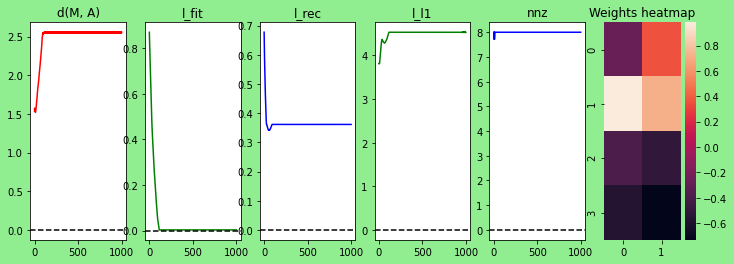

{'step.l1_coeff': 1e-05, 'step.l_rec_coeff': 1.0, 'get_results.batch_size': 128, 'repetitions': 1, 'name': 'sweep-02', '_meta': {'param_1': 'step.l_rec_coeff', 'param_2': 'step.l1_coeff'}}


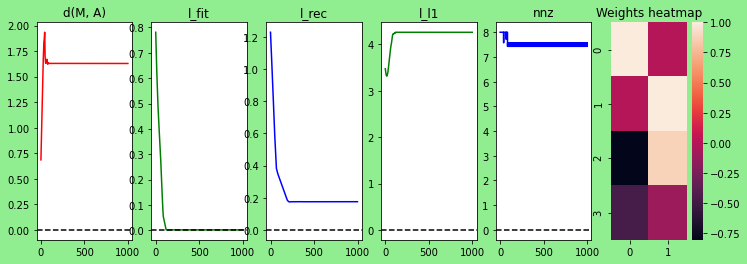

{'step.l1_coeff': 1e-05, 'step.l_rec_coeff': 1.0, 'get_results.batch_size': 128, 'repetitions': 2, 'name': 'sweep-02', '_meta': {'param_1': 'step.l_rec_coeff', 'param_2': 'step.l1_coeff'}}


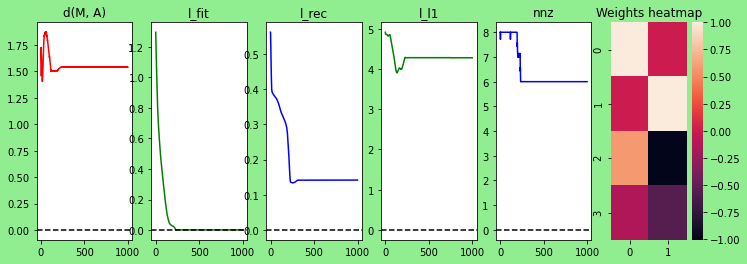

{'step.l1_coeff': 1e-05, 'step.l_rec_coeff': 1.0, 'get_results.batch_size': 128, 'repetitions': 3, 'name': 'sweep-02', '_meta': {'param_1': 'step.l_rec_coeff', 'param_2': 'step.l1_coeff'}}


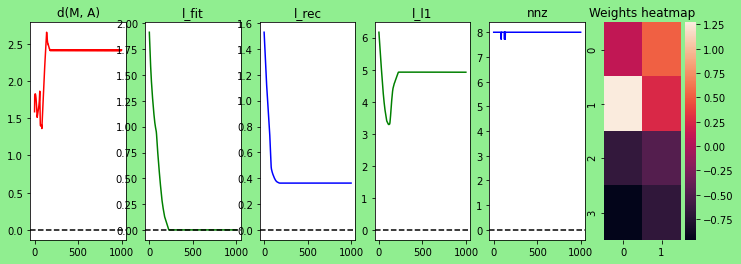

{'step.l1_coeff': 1e-05, 'step.l_rec_coeff': 1.0, 'get_results.batch_size': 128, 'repetitions': 4, 'name': 'sweep-02', '_meta': {'param_1': 'step.l_rec_coeff', 'param_2': 'step.l1_coeff'}}


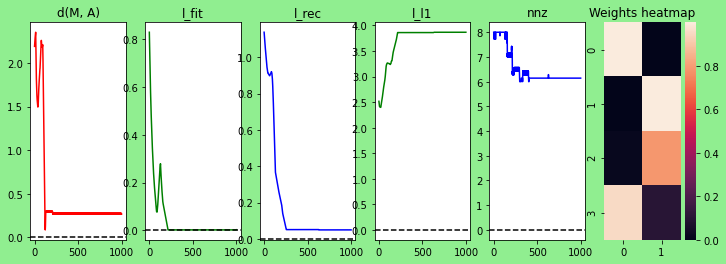

{'step.l1_coeff': 1e-05, 'step.l_rec_coeff': 3.1622776601683795, 'get_results.batch_size': 128, 'repetitions': 0, 'name': 'sweep-02', '_meta': {'param_1': 'step.l_rec_coeff', 'param_2': 'step.l1_coeff'}}


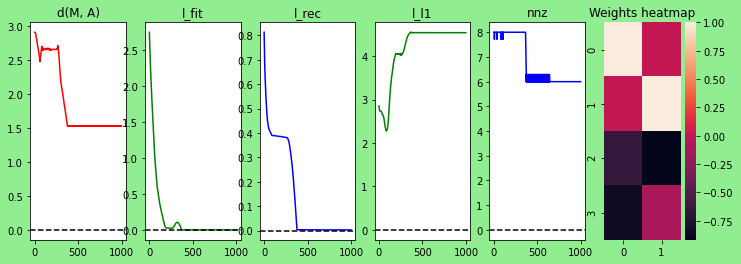

{'step.l1_coeff': 1e-05, 'step.l_rec_coeff': 3.1622776601683795, 'get_results.batch_size': 128, 'repetitions': 1, 'name': 'sweep-02', '_meta': {'param_1': 'step.l_rec_coeff', 'param_2': 'step.l1_coeff'}}


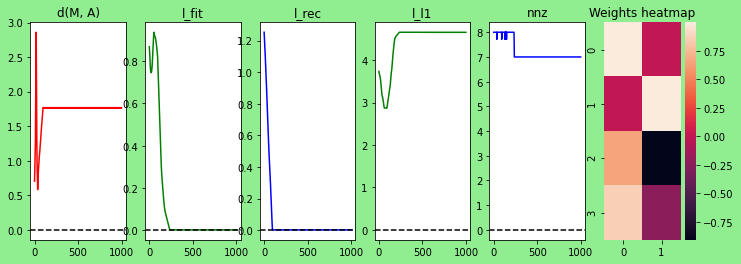

{'step.l1_coeff': 1e-05, 'step.l_rec_coeff': 3.1622776601683795, 'get_results.batch_size': 128, 'repetitions': 2, 'name': 'sweep-02', '_meta': {'param_1': 'step.l_rec_coeff', 'param_2': 'step.l1_coeff'}}


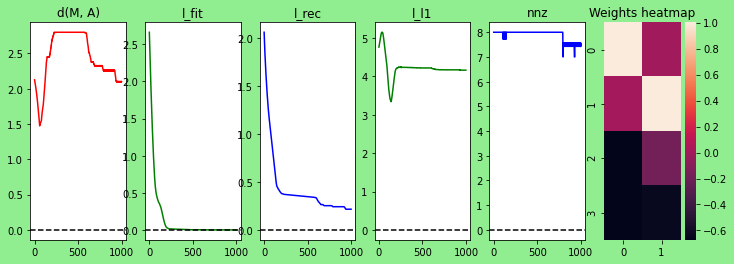

{'step.l1_coeff': 1e-05, 'step.l_rec_coeff': 3.1622776601683795, 'get_results.batch_size': 128, 'repetitions': 3, 'name': 'sweep-02', '_meta': {'param_1': 'step.l_rec_coeff', 'param_2': 'step.l1_coeff'}}


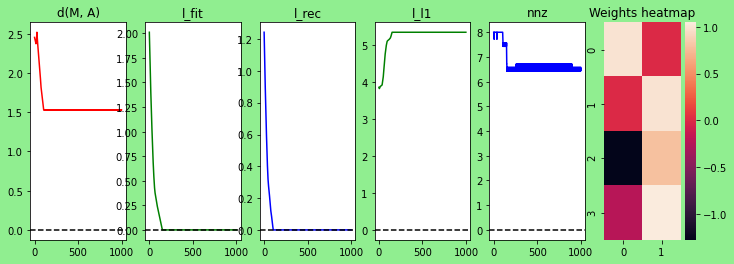

{'step.l1_coeff': 1e-05, 'step.l_rec_coeff': 3.1622776601683795, 'get_results.batch_size': 128, 'repetitions': 4, 'name': 'sweep-02', '_meta': {'param_1': 'step.l_rec_coeff', 'param_2': 'step.l1_coeff'}}


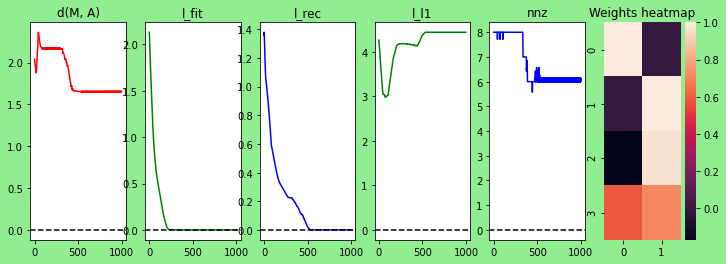

{'step.l1_coeff': 1e-05, 'step.l_rec_coeff': 10.0, 'get_results.batch_size': 128, 'repetitions': 0, 'name': 'sweep-02', '_meta': {'param_1': 'step.l_rec_coeff', 'param_2': 'step.l1_coeff'}}


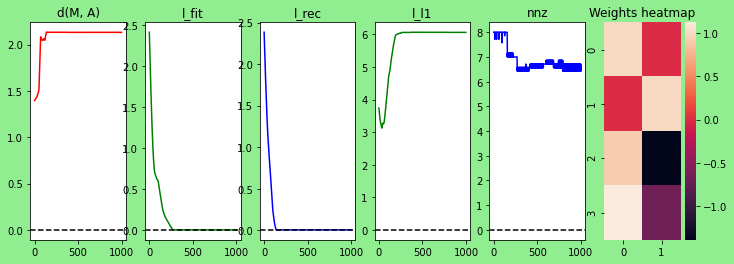

{'step.l1_coeff': 1e-05, 'step.l_rec_coeff': 10.0, 'get_results.batch_size': 128, 'repetitions': 1, 'name': 'sweep-02', '_meta': {'param_1': 'step.l_rec_coeff', 'param_2': 'step.l1_coeff'}}


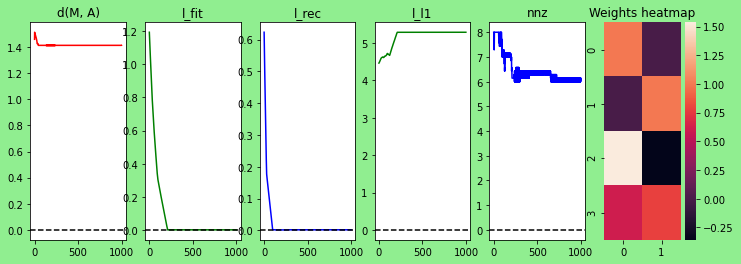

{'step.l1_coeff': 1e-05, 'step.l_rec_coeff': 10.0, 'get_results.batch_size': 128, 'repetitions': 2, 'name': 'sweep-02', '_meta': {'param_1': 'step.l_rec_coeff', 'param_2': 'step.l1_coeff'}}


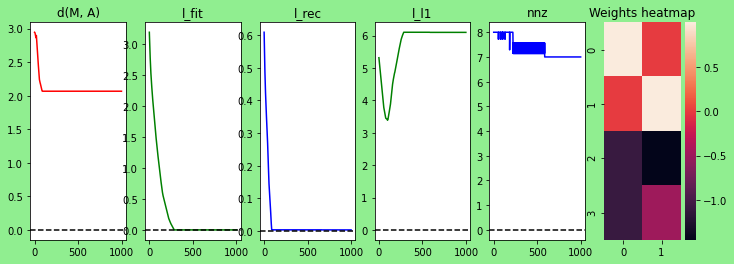

{'step.l1_coeff': 1e-05, 'step.l_rec_coeff': 10.0, 'get_results.batch_size': 128, 'repetitions': 3, 'name': 'sweep-02', '_meta': {'param_1': 'step.l_rec_coeff', 'param_2': 'step.l1_coeff'}}


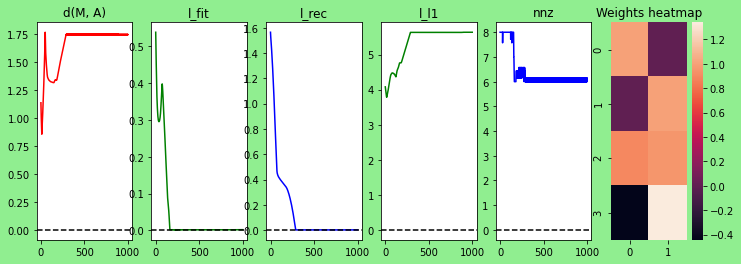

{'step.l1_coeff': 1e-05, 'step.l_rec_coeff': 10.0, 'get_results.batch_size': 128, 'repetitions': 4, 'name': 'sweep-02', '_meta': {'param_1': 'step.l_rec_coeff', 'param_2': 'step.l1_coeff'}}


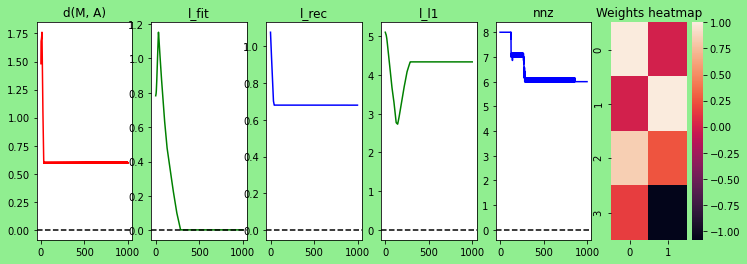

{'step.l1_coeff': 5.994842503189409e-05, 'step.l_rec_coeff': 1.0, 'get_results.batch_size': 128, 'repetitions': 0, 'name': 'sweep-02', '_meta': {'param_1': 'step.l_rec_coeff', 'param_2': 'step.l1_coeff'}}


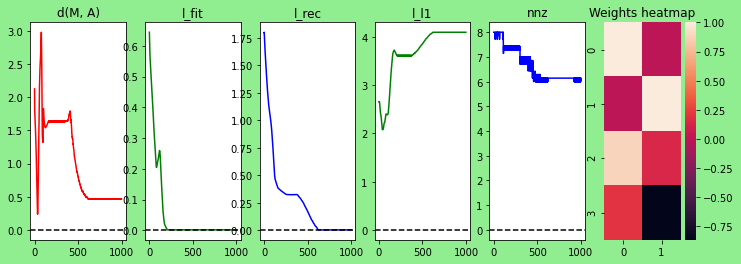

{'step.l1_coeff': 5.994842503189409e-05, 'step.l_rec_coeff': 1.0, 'get_results.batch_size': 128, 'repetitions': 1, 'name': 'sweep-02', '_meta': {'param_1': 'step.l_rec_coeff', 'param_2': 'step.l1_coeff'}}


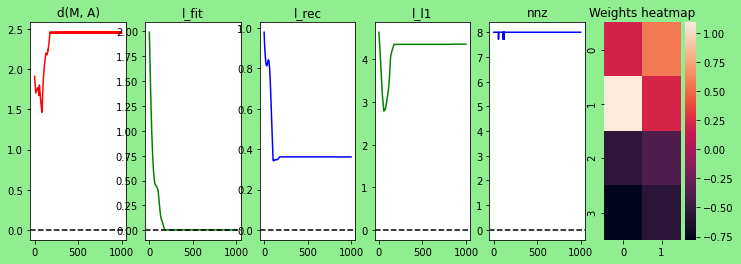

{'step.l1_coeff': 5.994842503189409e-05, 'step.l_rec_coeff': 1.0, 'get_results.batch_size': 128, 'repetitions': 2, 'name': 'sweep-02', '_meta': {'param_1': 'step.l_rec_coeff', 'param_2': 'step.l1_coeff'}}


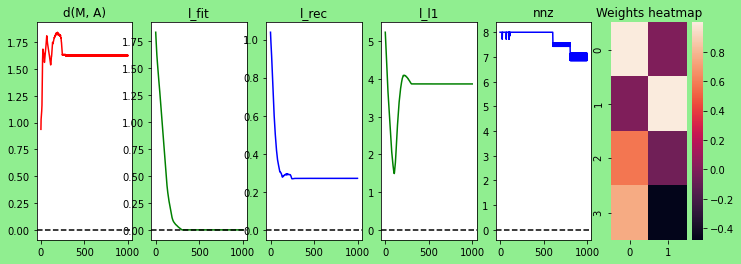

{'step.l1_coeff': 5.994842503189409e-05, 'step.l_rec_coeff': 1.0, 'get_results.batch_size': 128, 'repetitions': 3, 'name': 'sweep-02', '_meta': {'param_1': 'step.l_rec_coeff', 'param_2': 'step.l1_coeff'}}


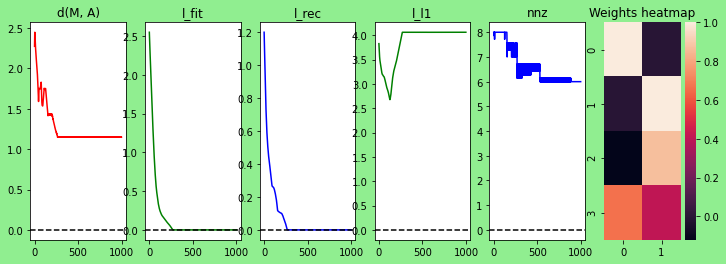

{'step.l1_coeff': 5.994842503189409e-05, 'step.l_rec_coeff': 1.0, 'get_results.batch_size': 128, 'repetitions': 4, 'name': 'sweep-02', '_meta': {'param_1': 'step.l_rec_coeff', 'param_2': 'step.l1_coeff'}}


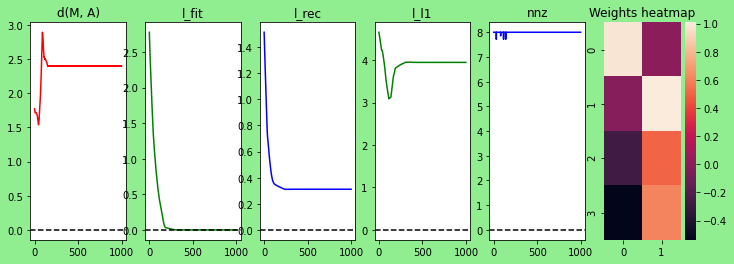

{'step.l1_coeff': 5.994842503189409e-05, 'step.l_rec_coeff': 3.1622776601683795, 'get_results.batch_size': 128, 'repetitions': 0, 'name': 'sweep-02', '_meta': {'param_1': 'step.l_rec_coeff', 'param_2': 'step.l1_coeff'}}


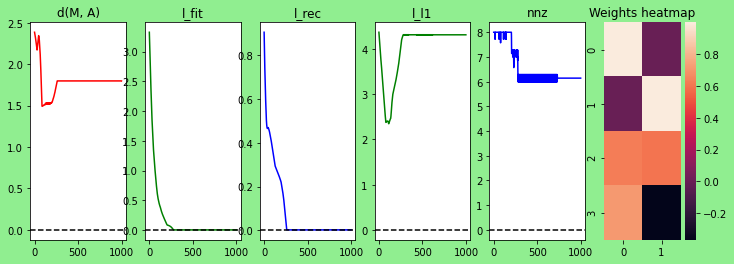

{'step.l1_coeff': 5.994842503189409e-05, 'step.l_rec_coeff': 3.1622776601683795, 'get_results.batch_size': 128, 'repetitions': 1, 'name': 'sweep-02', '_meta': {'param_1': 'step.l_rec_coeff', 'param_2': 'step.l1_coeff'}}


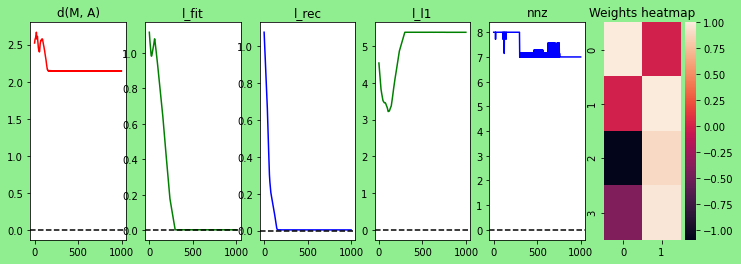

{'step.l1_coeff': 5.994842503189409e-05, 'step.l_rec_coeff': 3.1622776601683795, 'get_results.batch_size': 128, 'repetitions': 2, 'name': 'sweep-02', '_meta': {'param_1': 'step.l_rec_coeff', 'param_2': 'step.l1_coeff'}}


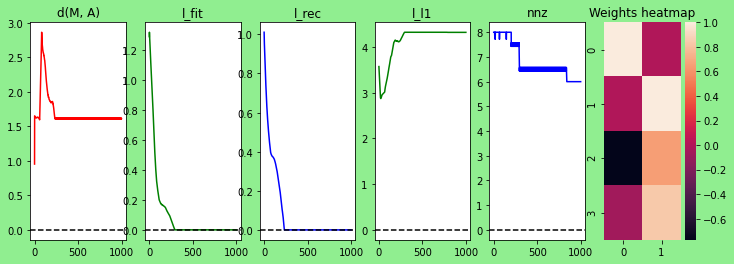

{'step.l1_coeff': 5.994842503189409e-05, 'step.l_rec_coeff': 3.1622776601683795, 'get_results.batch_size': 128, 'repetitions': 3, 'name': 'sweep-02', '_meta': {'param_1': 'step.l_rec_coeff', 'param_2': 'step.l1_coeff'}}


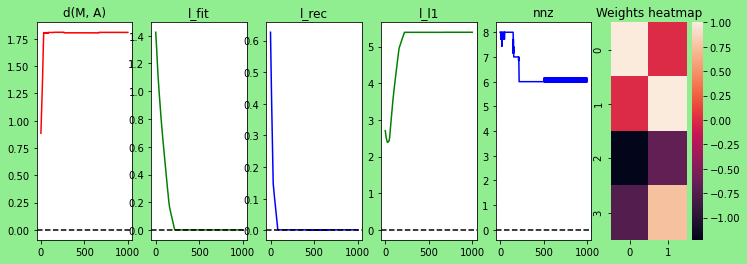

{'step.l1_coeff': 5.994842503189409e-05, 'step.l_rec_coeff': 3.1622776601683795, 'get_results.batch_size': 128, 'repetitions': 4, 'name': 'sweep-02', '_meta': {'param_1': 'step.l_rec_coeff', 'param_2': 'step.l1_coeff'}}


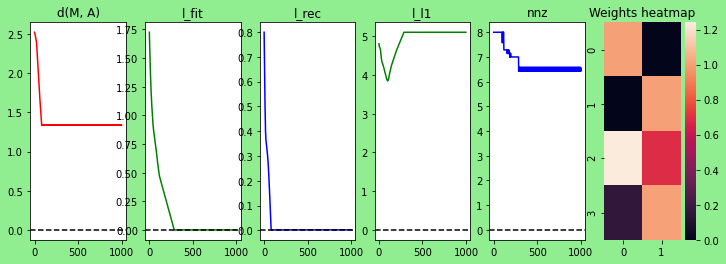

{'step.l1_coeff': 5.994842503189409e-05, 'step.l_rec_coeff': 10.0, 'get_results.batch_size': 128, 'repetitions': 0, 'name': 'sweep-02', '_meta': {'param_1': 'step.l_rec_coeff', 'param_2': 'step.l1_coeff'}}


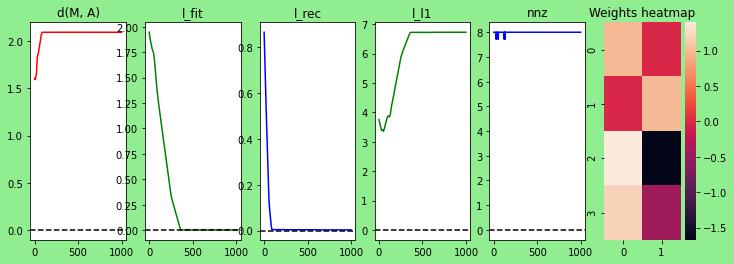

{'step.l1_coeff': 5.994842503189409e-05, 'step.l_rec_coeff': 10.0, 'get_results.batch_size': 128, 'repetitions': 1, 'name': 'sweep-02', '_meta': {'param_1': 'step.l_rec_coeff', 'param_2': 'step.l1_coeff'}}


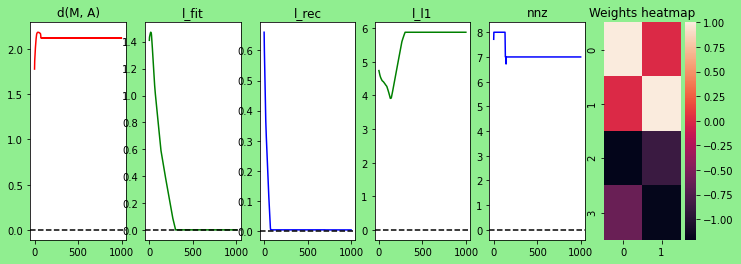

{'step.l1_coeff': 5.994842503189409e-05, 'step.l_rec_coeff': 10.0, 'get_results.batch_size': 128, 'repetitions': 2, 'name': 'sweep-02', '_meta': {'param_1': 'step.l_rec_coeff', 'param_2': 'step.l1_coeff'}}


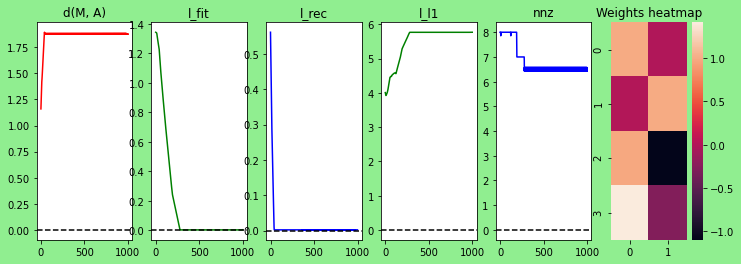

{'step.l1_coeff': 5.994842503189409e-05, 'step.l_rec_coeff': 10.0, 'get_results.batch_size': 128, 'repetitions': 3, 'name': 'sweep-02', '_meta': {'param_1': 'step.l_rec_coeff', 'param_2': 'step.l1_coeff'}}


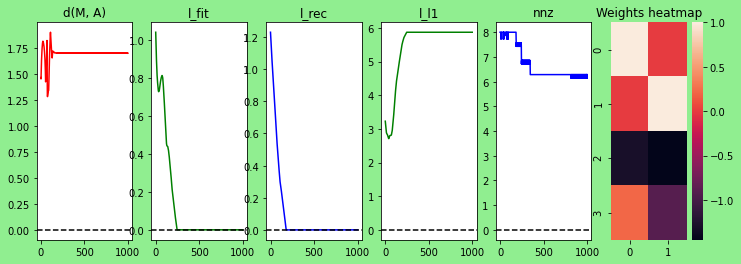

{'step.l1_coeff': 5.994842503189409e-05, 'step.l_rec_coeff': 10.0, 'get_results.batch_size': 128, 'repetitions': 4, 'name': 'sweep-02', '_meta': {'param_1': 'step.l_rec_coeff', 'param_2': 'step.l1_coeff'}}


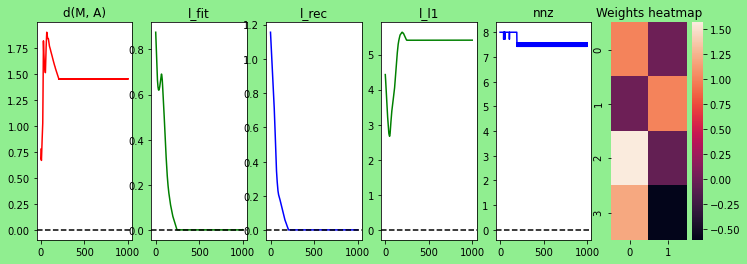

{'step.l1_coeff': 0.00035938136638046257, 'step.l_rec_coeff': 1.0, 'get_results.batch_size': 128, 'repetitions': 0, 'name': 'sweep-02', '_meta': {'param_1': 'step.l_rec_coeff', 'param_2': 'step.l1_coeff'}}


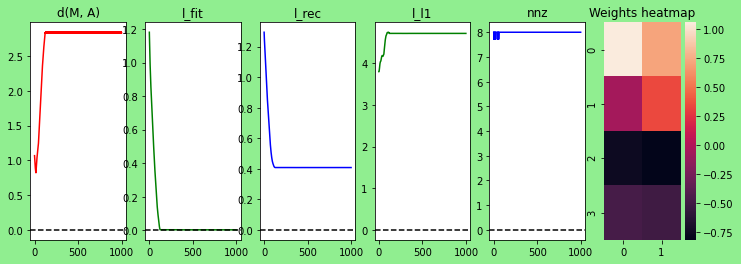

{'step.l1_coeff': 0.00035938136638046257, 'step.l_rec_coeff': 1.0, 'get_results.batch_size': 128, 'repetitions': 1, 'name': 'sweep-02', '_meta': {'param_1': 'step.l_rec_coeff', 'param_2': 'step.l1_coeff'}}


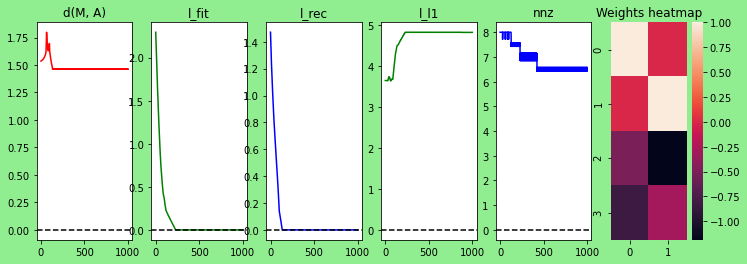

{'step.l1_coeff': 0.00035938136638046257, 'step.l_rec_coeff': 1.0, 'get_results.batch_size': 128, 'repetitions': 2, 'name': 'sweep-02', '_meta': {'param_1': 'step.l_rec_coeff', 'param_2': 'step.l1_coeff'}}


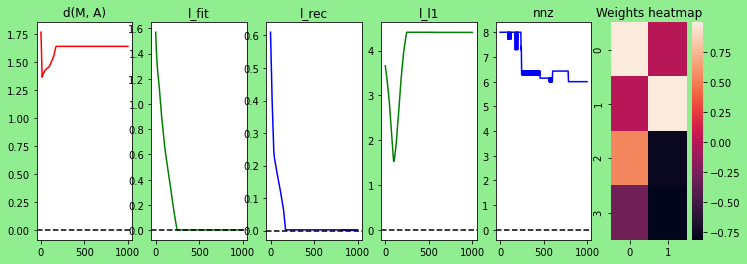

{'step.l1_coeff': 0.00035938136638046257, 'step.l_rec_coeff': 1.0, 'get_results.batch_size': 128, 'repetitions': 3, 'name': 'sweep-02', '_meta': {'param_1': 'step.l_rec_coeff', 'param_2': 'step.l1_coeff'}}


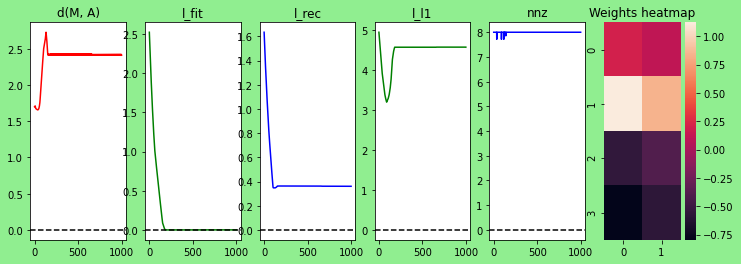

{'step.l1_coeff': 0.00035938136638046257, 'step.l_rec_coeff': 1.0, 'get_results.batch_size': 128, 'repetitions': 4, 'name': 'sweep-02', '_meta': {'param_1': 'step.l_rec_coeff', 'param_2': 'step.l1_coeff'}}


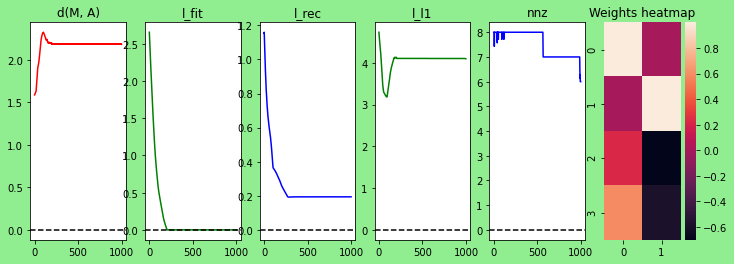

{'step.l1_coeff': 0.00035938136638046257, 'step.l_rec_coeff': 3.1622776601683795, 'get_results.batch_size': 128, 'repetitions': 0, 'name': 'sweep-02', '_meta': {'param_1': 'step.l_rec_coeff', 'param_2': 'step.l1_coeff'}}


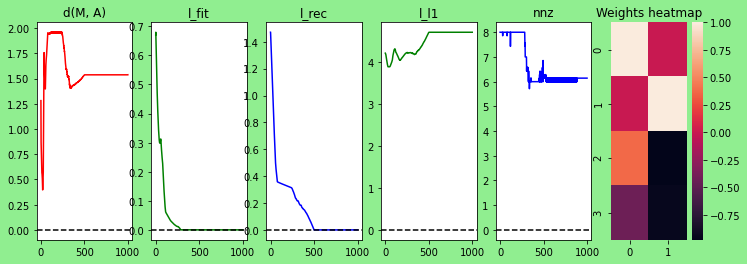

{'step.l1_coeff': 0.00035938136638046257, 'step.l_rec_coeff': 3.1622776601683795, 'get_results.batch_size': 128, 'repetitions': 1, 'name': 'sweep-02', '_meta': {'param_1': 'step.l_rec_coeff', 'param_2': 'step.l1_coeff'}}


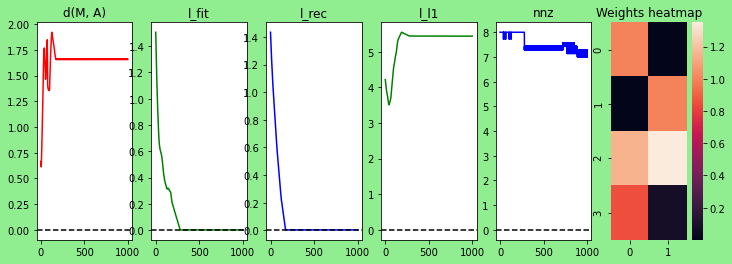

{'step.l1_coeff': 0.00035938136638046257, 'step.l_rec_coeff': 3.1622776601683795, 'get_results.batch_size': 128, 'repetitions': 2, 'name': 'sweep-02', '_meta': {'param_1': 'step.l_rec_coeff', 'param_2': 'step.l1_coeff'}}


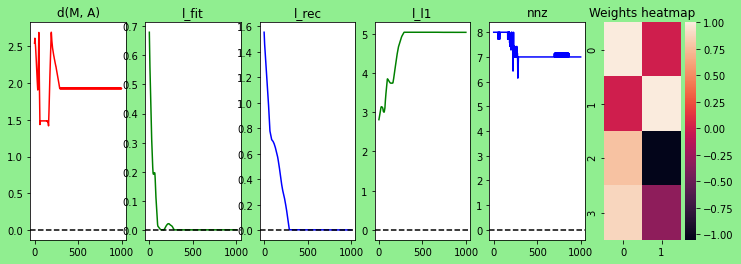

{'step.l1_coeff': 0.00035938136638046257, 'step.l_rec_coeff': 3.1622776601683795, 'get_results.batch_size': 128, 'repetitions': 3, 'name': 'sweep-02', '_meta': {'param_1': 'step.l_rec_coeff', 'param_2': 'step.l1_coeff'}}


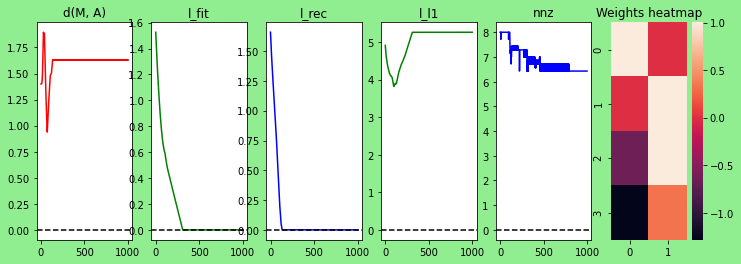

{'step.l1_coeff': 0.00035938136638046257, 'step.l_rec_coeff': 3.1622776601683795, 'get_results.batch_size': 128, 'repetitions': 4, 'name': 'sweep-02', '_meta': {'param_1': 'step.l_rec_coeff', 'param_2': 'step.l1_coeff'}}


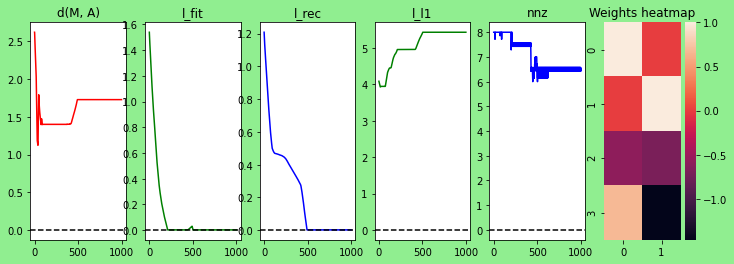

{'step.l1_coeff': 0.00035938136638046257, 'step.l_rec_coeff': 10.0, 'get_results.batch_size': 128, 'repetitions': 0, 'name': 'sweep-02', '_meta': {'param_1': 'step.l_rec_coeff', 'param_2': 'step.l1_coeff'}}


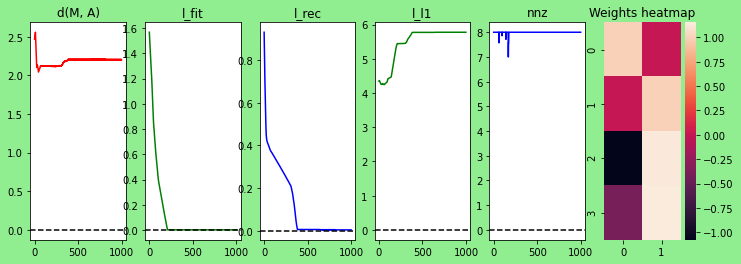

{'step.l1_coeff': 0.00035938136638046257, 'step.l_rec_coeff': 10.0, 'get_results.batch_size': 128, 'repetitions': 1, 'name': 'sweep-02', '_meta': {'param_1': 'step.l_rec_coeff', 'param_2': 'step.l1_coeff'}}


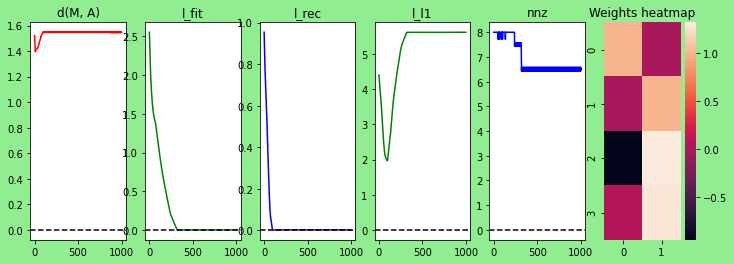

{'step.l1_coeff': 0.00035938136638046257, 'step.l_rec_coeff': 10.0, 'get_results.batch_size': 128, 'repetitions': 2, 'name': 'sweep-02', '_meta': {'param_1': 'step.l_rec_coeff', 'param_2': 'step.l1_coeff'}}


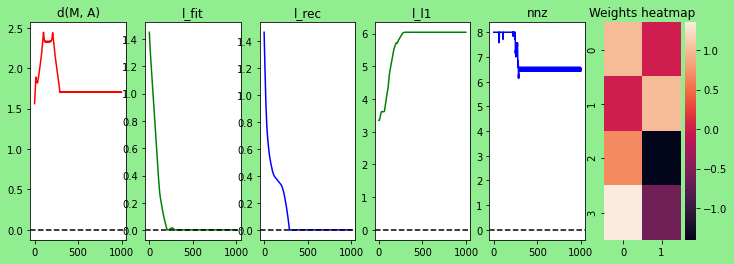

{'step.l1_coeff': 0.00035938136638046257, 'step.l_rec_coeff': 10.0, 'get_results.batch_size': 128, 'repetitions': 3, 'name': 'sweep-02', '_meta': {'param_1': 'step.l_rec_coeff', 'param_2': 'step.l1_coeff'}}


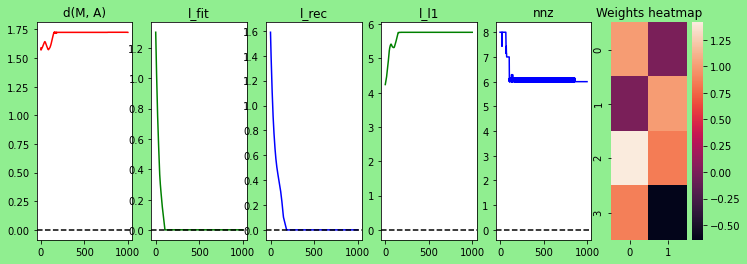

{'step.l1_coeff': 0.00035938136638046257, 'step.l_rec_coeff': 10.0, 'get_results.batch_size': 128, 'repetitions': 4, 'name': 'sweep-02', '_meta': {'param_1': 'step.l_rec_coeff', 'param_2': 'step.l1_coeff'}}


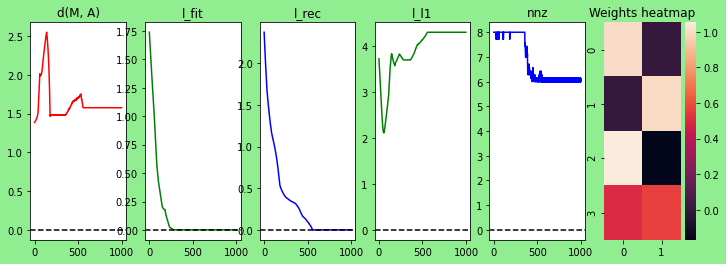

{'step.l1_coeff': 0.0021544346900318843, 'step.l_rec_coeff': 1.0, 'get_results.batch_size': 128, 'repetitions': 0, 'name': 'sweep-02', '_meta': {'param_1': 'step.l_rec_coeff', 'param_2': 'step.l1_coeff'}}


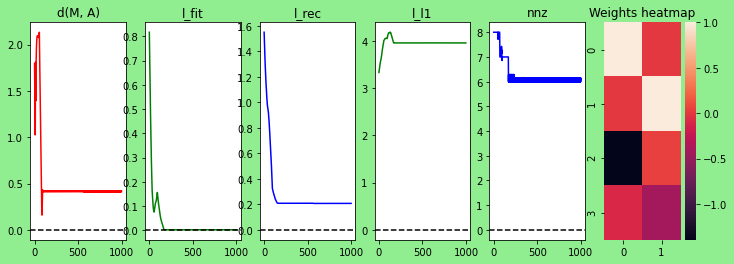

{'step.l1_coeff': 0.0021544346900318843, 'step.l_rec_coeff': 1.0, 'get_results.batch_size': 128, 'repetitions': 1, 'name': 'sweep-02', '_meta': {'param_1': 'step.l_rec_coeff', 'param_2': 'step.l1_coeff'}}


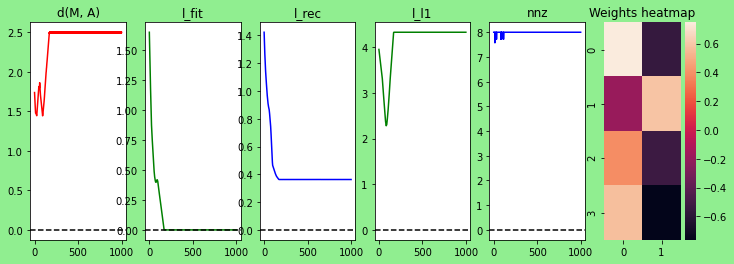

{'step.l1_coeff': 0.0021544346900318843, 'step.l_rec_coeff': 1.0, 'get_results.batch_size': 128, 'repetitions': 2, 'name': 'sweep-02', '_meta': {'param_1': 'step.l_rec_coeff', 'param_2': 'step.l1_coeff'}}


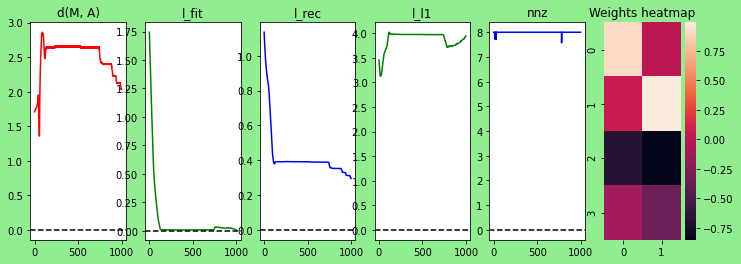

{'step.l1_coeff': 0.0021544346900318843, 'step.l_rec_coeff': 1.0, 'get_results.batch_size': 128, 'repetitions': 3, 'name': 'sweep-02', '_meta': {'param_1': 'step.l_rec_coeff', 'param_2': 'step.l1_coeff'}}


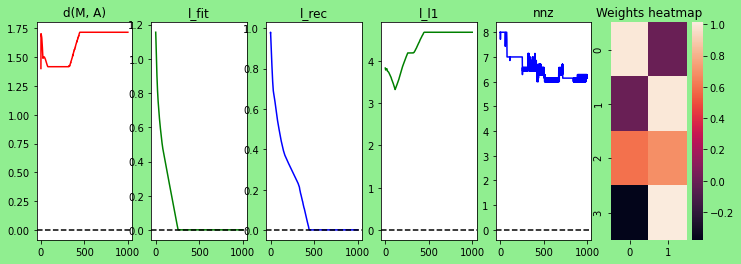

{'step.l1_coeff': 0.0021544346900318843, 'step.l_rec_coeff': 1.0, 'get_results.batch_size': 128, 'repetitions': 4, 'name': 'sweep-02', '_meta': {'param_1': 'step.l_rec_coeff', 'param_2': 'step.l1_coeff'}}


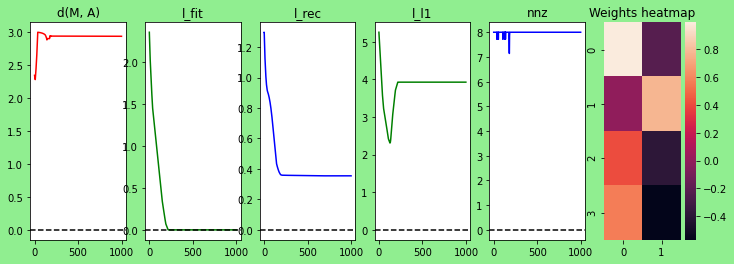

{'step.l1_coeff': 0.0021544346900318843, 'step.l_rec_coeff': 3.1622776601683795, 'get_results.batch_size': 128, 'repetitions': 0, 'name': 'sweep-02', '_meta': {'param_1': 'step.l_rec_coeff', 'param_2': 'step.l1_coeff'}}


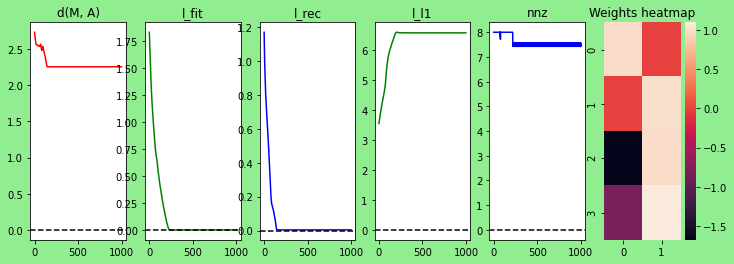

{'step.l1_coeff': 0.0021544346900318843, 'step.l_rec_coeff': 3.1622776601683795, 'get_results.batch_size': 128, 'repetitions': 1, 'name': 'sweep-02', '_meta': {'param_1': 'step.l_rec_coeff', 'param_2': 'step.l1_coeff'}}


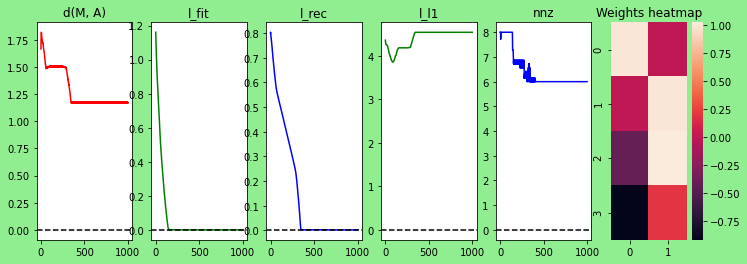

{'step.l1_coeff': 0.0021544346900318843, 'step.l_rec_coeff': 3.1622776601683795, 'get_results.batch_size': 128, 'repetitions': 2, 'name': 'sweep-02', '_meta': {'param_1': 'step.l_rec_coeff', 'param_2': 'step.l1_coeff'}}


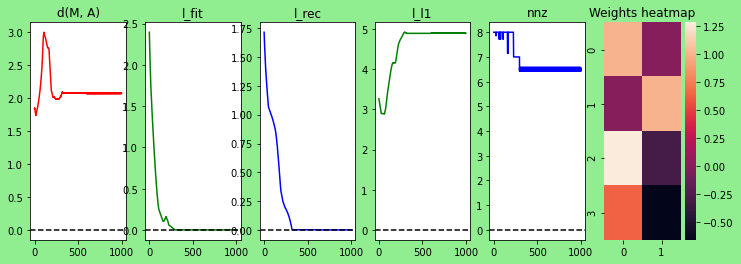

{'step.l1_coeff': 0.0021544346900318843, 'step.l_rec_coeff': 3.1622776601683795, 'get_results.batch_size': 128, 'repetitions': 3, 'name': 'sweep-02', '_meta': {'param_1': 'step.l_rec_coeff', 'param_2': 'step.l1_coeff'}}


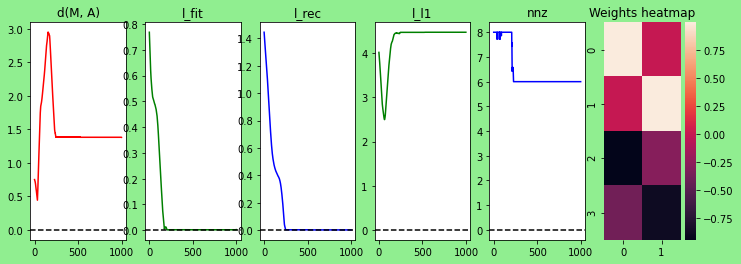

{'step.l1_coeff': 0.0021544346900318843, 'step.l_rec_coeff': 3.1622776601683795, 'get_results.batch_size': 128, 'repetitions': 4, 'name': 'sweep-02', '_meta': {'param_1': 'step.l_rec_coeff', 'param_2': 'step.l1_coeff'}}


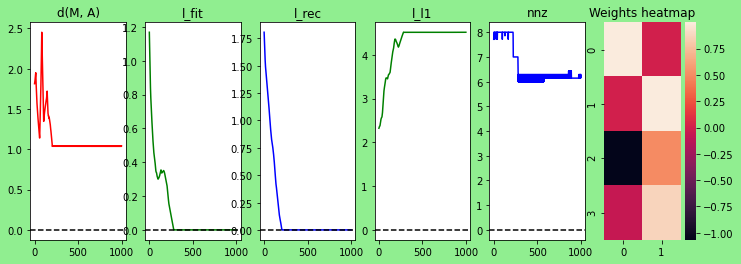

{'step.l1_coeff': 0.0021544346900318843, 'step.l_rec_coeff': 10.0, 'get_results.batch_size': 128, 'repetitions': 0, 'name': 'sweep-02', '_meta': {'param_1': 'step.l_rec_coeff', 'param_2': 'step.l1_coeff'}}


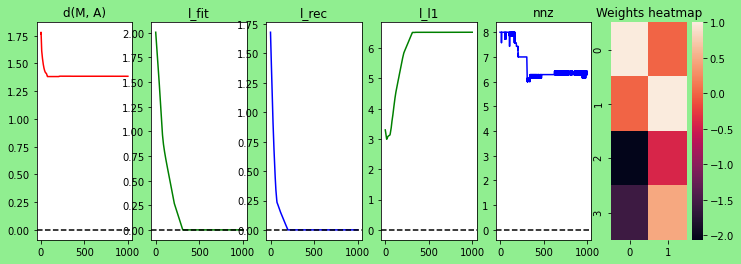

{'step.l1_coeff': 0.0021544346900318843, 'step.l_rec_coeff': 10.0, 'get_results.batch_size': 128, 'repetitions': 1, 'name': 'sweep-02', '_meta': {'param_1': 'step.l_rec_coeff', 'param_2': 'step.l1_coeff'}}


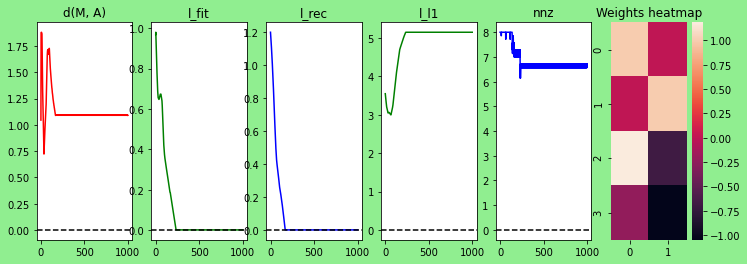

{'step.l1_coeff': 0.0021544346900318843, 'step.l_rec_coeff': 10.0, 'get_results.batch_size': 128, 'repetitions': 2, 'name': 'sweep-02', '_meta': {'param_1': 'step.l_rec_coeff', 'param_2': 'step.l1_coeff'}}


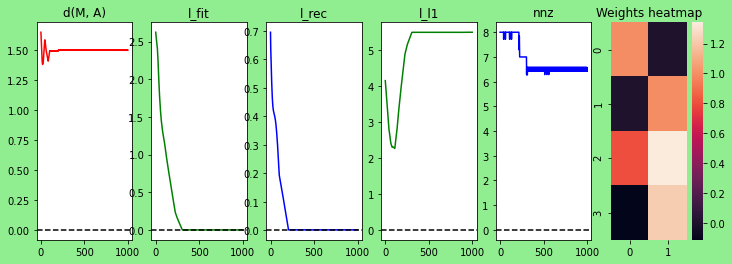

{'step.l1_coeff': 0.0021544346900318843, 'step.l_rec_coeff': 10.0, 'get_results.batch_size': 128, 'repetitions': 3, 'name': 'sweep-02', '_meta': {'param_1': 'step.l_rec_coeff', 'param_2': 'step.l1_coeff'}}


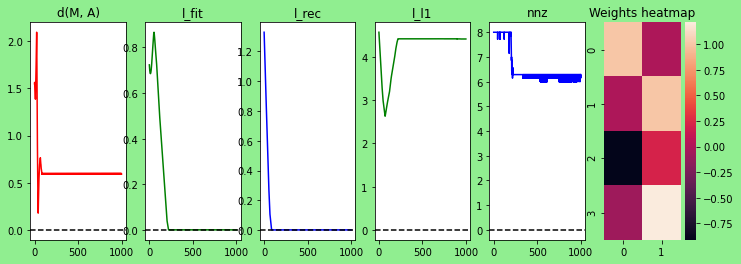

{'step.l1_coeff': 0.0021544346900318843, 'step.l_rec_coeff': 10.0, 'get_results.batch_size': 128, 'repetitions': 4, 'name': 'sweep-02', '_meta': {'param_1': 'step.l_rec_coeff', 'param_2': 'step.l1_coeff'}}


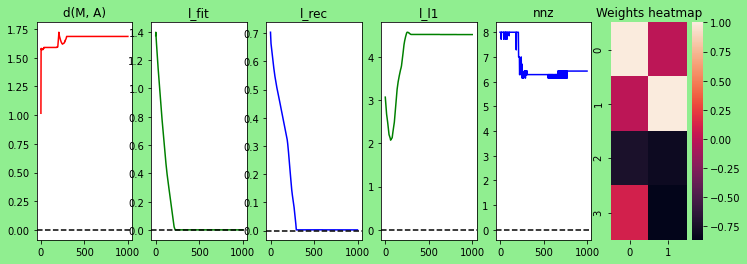

{'step.l1_coeff': 0.01291549665014884, 'step.l_rec_coeff': 1.0, 'get_results.batch_size': 128, 'repetitions': 0, 'name': 'sweep-02', '_meta': {'param_1': 'step.l_rec_coeff', 'param_2': 'step.l1_coeff'}}


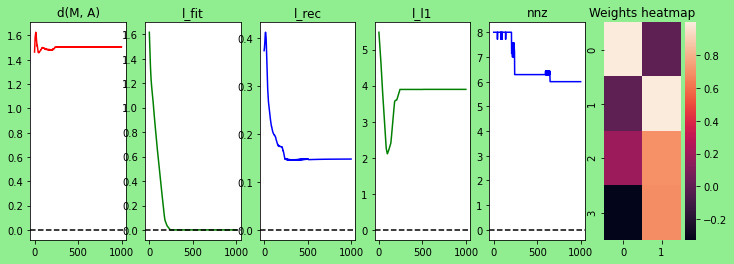

{'step.l1_coeff': 0.01291549665014884, 'step.l_rec_coeff': 1.0, 'get_results.batch_size': 128, 'repetitions': 1, 'name': 'sweep-02', '_meta': {'param_1': 'step.l_rec_coeff', 'param_2': 'step.l1_coeff'}}


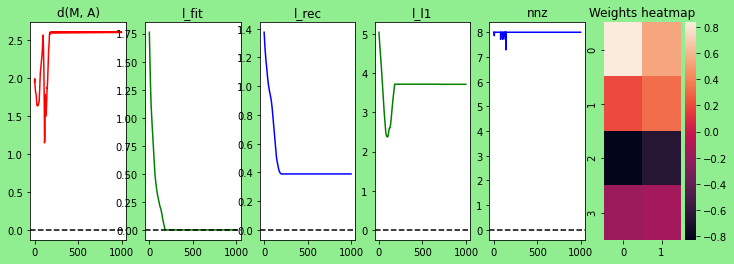

{'step.l1_coeff': 0.01291549665014884, 'step.l_rec_coeff': 1.0, 'get_results.batch_size': 128, 'repetitions': 2, 'name': 'sweep-02', '_meta': {'param_1': 'step.l_rec_coeff', 'param_2': 'step.l1_coeff'}}


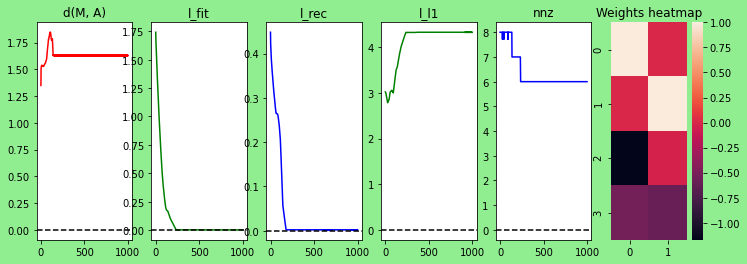

{'step.l1_coeff': 0.01291549665014884, 'step.l_rec_coeff': 1.0, 'get_results.batch_size': 128, 'repetitions': 3, 'name': 'sweep-02', '_meta': {'param_1': 'step.l_rec_coeff', 'param_2': 'step.l1_coeff'}}


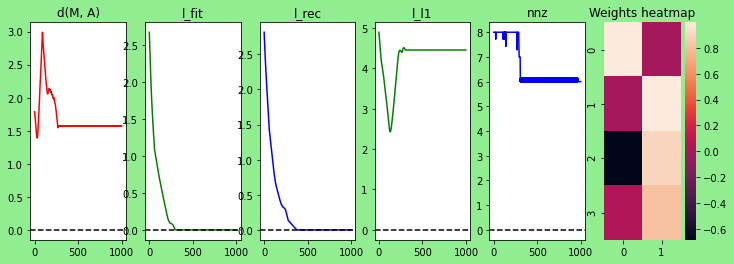

{'step.l1_coeff': 0.01291549665014884, 'step.l_rec_coeff': 1.0, 'get_results.batch_size': 128, 'repetitions': 4, 'name': 'sweep-02', '_meta': {'param_1': 'step.l_rec_coeff', 'param_2': 'step.l1_coeff'}}


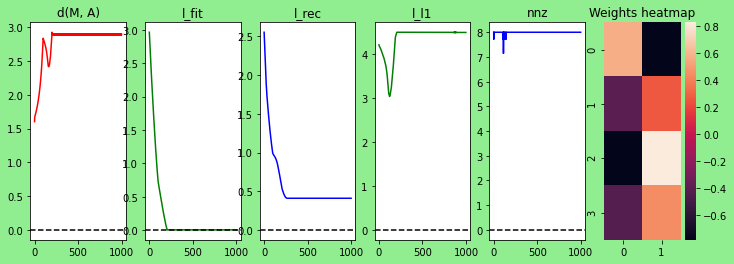

{'step.l1_coeff': 0.01291549665014884, 'step.l_rec_coeff': 3.1622776601683795, 'get_results.batch_size': 128, 'repetitions': 0, 'name': 'sweep-02', '_meta': {'param_1': 'step.l_rec_coeff', 'param_2': 'step.l1_coeff'}}


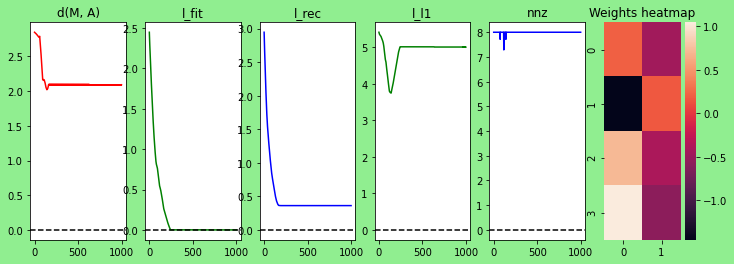

{'step.l1_coeff': 0.01291549665014884, 'step.l_rec_coeff': 3.1622776601683795, 'get_results.batch_size': 128, 'repetitions': 1, 'name': 'sweep-02', '_meta': {'param_1': 'step.l_rec_coeff', 'param_2': 'step.l1_coeff'}}


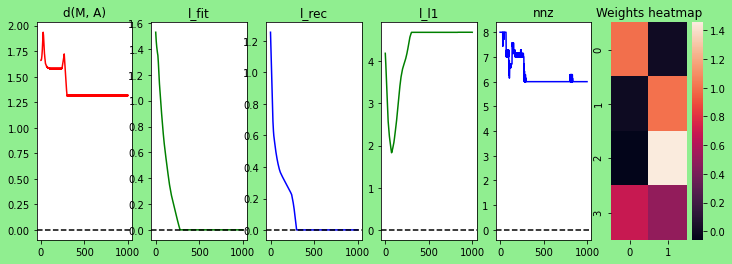

{'step.l1_coeff': 0.01291549665014884, 'step.l_rec_coeff': 3.1622776601683795, 'get_results.batch_size': 128, 'repetitions': 2, 'name': 'sweep-02', '_meta': {'param_1': 'step.l_rec_coeff', 'param_2': 'step.l1_coeff'}}


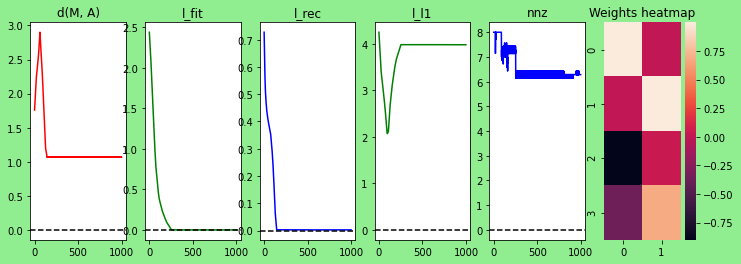

{'step.l1_coeff': 0.01291549665014884, 'step.l_rec_coeff': 3.1622776601683795, 'get_results.batch_size': 128, 'repetitions': 3, 'name': 'sweep-02', '_meta': {'param_1': 'step.l_rec_coeff', 'param_2': 'step.l1_coeff'}}


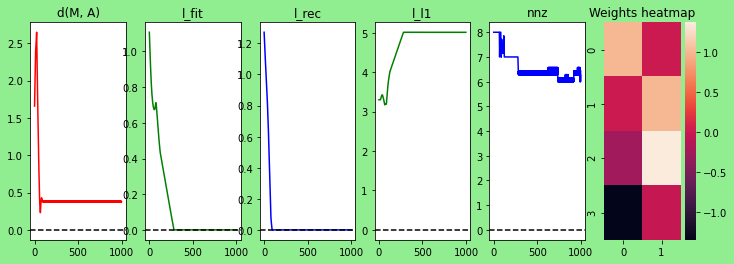

{'step.l1_coeff': 0.01291549665014884, 'step.l_rec_coeff': 3.1622776601683795, 'get_results.batch_size': 128, 'repetitions': 4, 'name': 'sweep-02', '_meta': {'param_1': 'step.l_rec_coeff', 'param_2': 'step.l1_coeff'}}


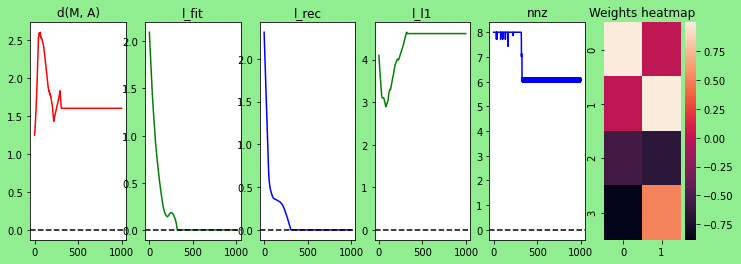

{'step.l1_coeff': 0.01291549665014884, 'step.l_rec_coeff': 10.0, 'get_results.batch_size': 128, 'repetitions': 0, 'name': 'sweep-02', '_meta': {'param_1': 'step.l_rec_coeff', 'param_2': 'step.l1_coeff'}}


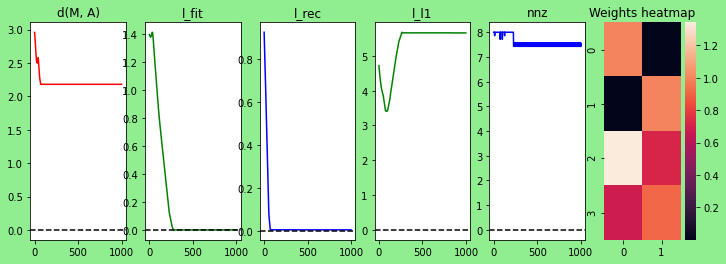

{'step.l1_coeff': 0.01291549665014884, 'step.l_rec_coeff': 10.0, 'get_results.batch_size': 128, 'repetitions': 1, 'name': 'sweep-02', '_meta': {'param_1': 'step.l_rec_coeff', 'param_2': 'step.l1_coeff'}}


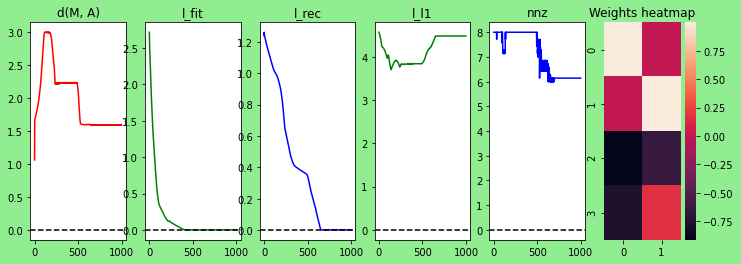

{'step.l1_coeff': 0.01291549665014884, 'step.l_rec_coeff': 10.0, 'get_results.batch_size': 128, 'repetitions': 2, 'name': 'sweep-02', '_meta': {'param_1': 'step.l_rec_coeff', 'param_2': 'step.l1_coeff'}}


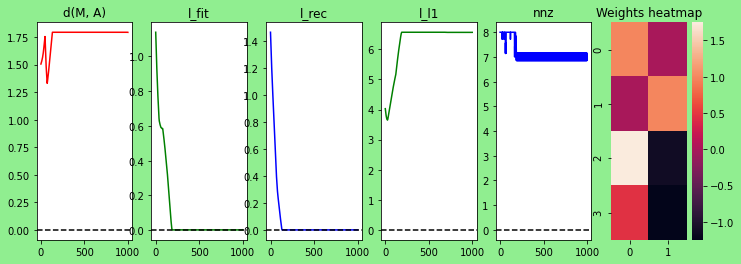

{'step.l1_coeff': 0.01291549665014884, 'step.l_rec_coeff': 10.0, 'get_results.batch_size': 128, 'repetitions': 3, 'name': 'sweep-02', '_meta': {'param_1': 'step.l_rec_coeff', 'param_2': 'step.l1_coeff'}}


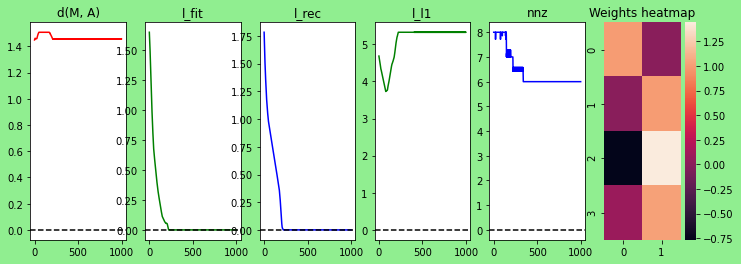

{'step.l1_coeff': 0.01291549665014884, 'step.l_rec_coeff': 10.0, 'get_results.batch_size': 128, 'repetitions': 4, 'name': 'sweep-02', '_meta': {'param_1': 'step.l_rec_coeff', 'param_2': 'step.l1_coeff'}}


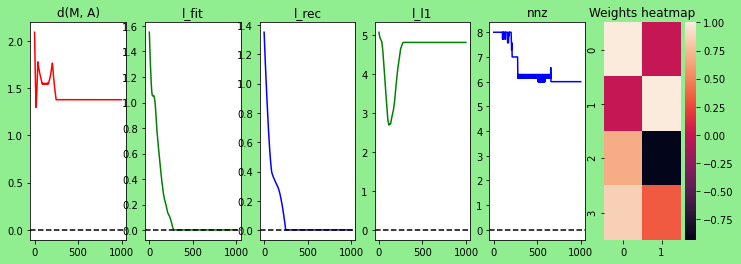

{'step.l1_coeff': 0.0774263682681127, 'step.l_rec_coeff': 1.0, 'get_results.batch_size': 128, 'repetitions': 0, 'name': 'sweep-02', '_meta': {'param_1': 'step.l_rec_coeff', 'param_2': 'step.l1_coeff'}}


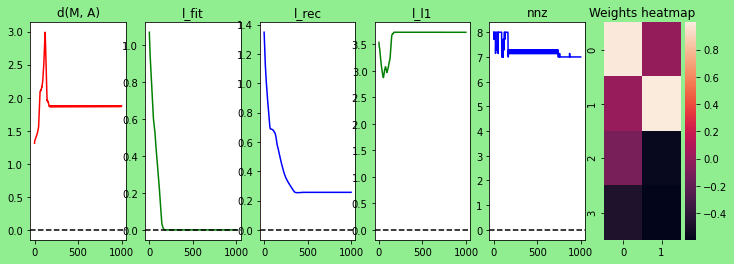

{'step.l1_coeff': 0.0774263682681127, 'step.l_rec_coeff': 1.0, 'get_results.batch_size': 128, 'repetitions': 1, 'name': 'sweep-02', '_meta': {'param_1': 'step.l_rec_coeff', 'param_2': 'step.l1_coeff'}}


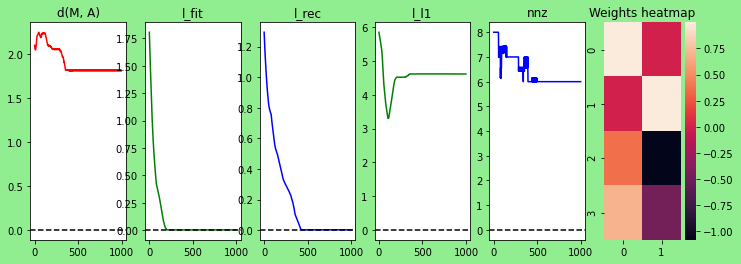

{'step.l1_coeff': 0.0774263682681127, 'step.l_rec_coeff': 1.0, 'get_results.batch_size': 128, 'repetitions': 2, 'name': 'sweep-02', '_meta': {'param_1': 'step.l_rec_coeff', 'param_2': 'step.l1_coeff'}}


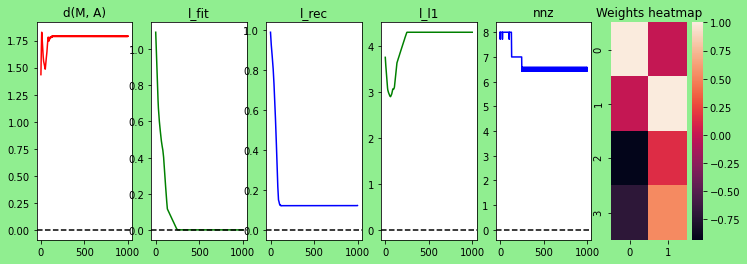

{'step.l1_coeff': 0.0774263682681127, 'step.l_rec_coeff': 1.0, 'get_results.batch_size': 128, 'repetitions': 3, 'name': 'sweep-02', '_meta': {'param_1': 'step.l_rec_coeff', 'param_2': 'step.l1_coeff'}}


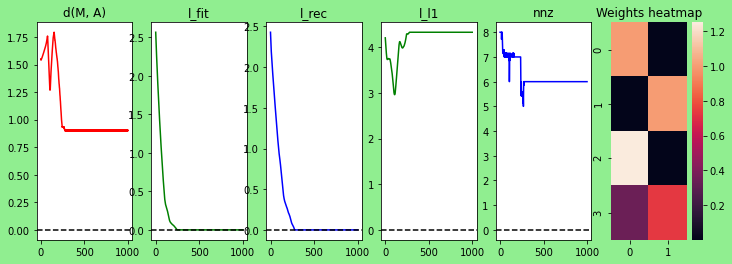

{'step.l1_coeff': 0.0774263682681127, 'step.l_rec_coeff': 1.0, 'get_results.batch_size': 128, 'repetitions': 4, 'name': 'sweep-02', '_meta': {'param_1': 'step.l_rec_coeff', 'param_2': 'step.l1_coeff'}}


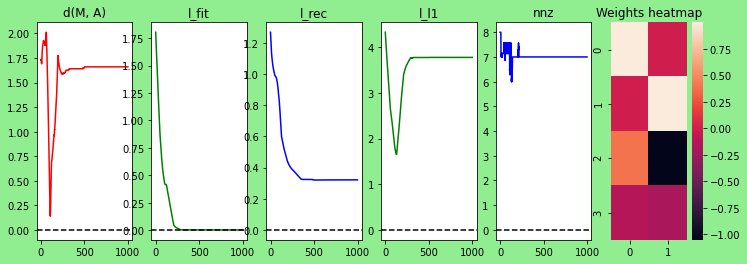

{'step.l1_coeff': 0.0774263682681127, 'step.l_rec_coeff': 3.1622776601683795, 'get_results.batch_size': 128, 'repetitions': 0, 'name': 'sweep-02', '_meta': {'param_1': 'step.l_rec_coeff', 'param_2': 'step.l1_coeff'}}


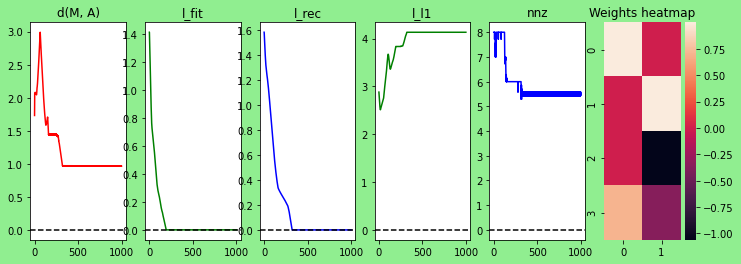

{'step.l1_coeff': 0.0774263682681127, 'step.l_rec_coeff': 3.1622776601683795, 'get_results.batch_size': 128, 'repetitions': 1, 'name': 'sweep-02', '_meta': {'param_1': 'step.l_rec_coeff', 'param_2': 'step.l1_coeff'}}


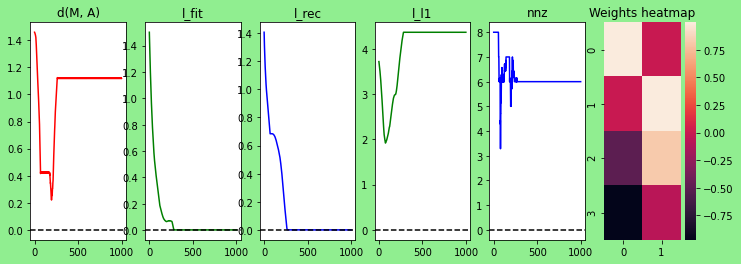

{'step.l1_coeff': 0.0774263682681127, 'step.l_rec_coeff': 3.1622776601683795, 'get_results.batch_size': 128, 'repetitions': 2, 'name': 'sweep-02', '_meta': {'param_1': 'step.l_rec_coeff', 'param_2': 'step.l1_coeff'}}


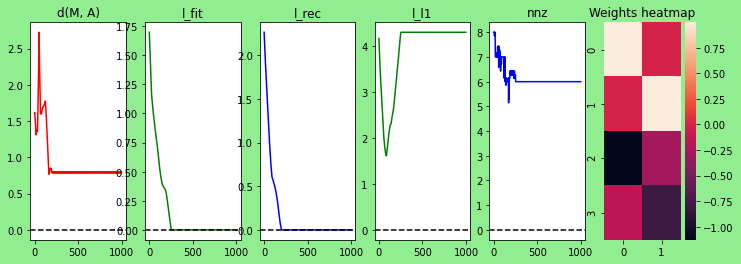

{'step.l1_coeff': 0.0774263682681127, 'step.l_rec_coeff': 3.1622776601683795, 'get_results.batch_size': 128, 'repetitions': 3, 'name': 'sweep-02', '_meta': {'param_1': 'step.l_rec_coeff', 'param_2': 'step.l1_coeff'}}


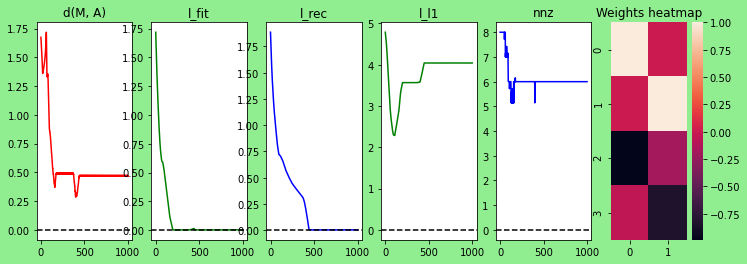

{'step.l1_coeff': 0.0774263682681127, 'step.l_rec_coeff': 3.1622776601683795, 'get_results.batch_size': 128, 'repetitions': 4, 'name': 'sweep-02', '_meta': {'param_1': 'step.l_rec_coeff', 'param_2': 'step.l1_coeff'}}


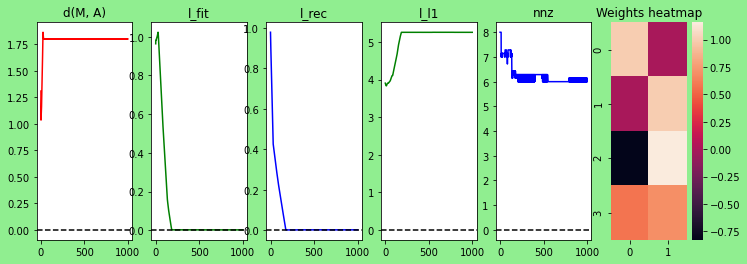

{'step.l1_coeff': 0.0774263682681127, 'step.l_rec_coeff': 10.0, 'get_results.batch_size': 128, 'repetitions': 0, 'name': 'sweep-02', '_meta': {'param_1': 'step.l_rec_coeff', 'param_2': 'step.l1_coeff'}}


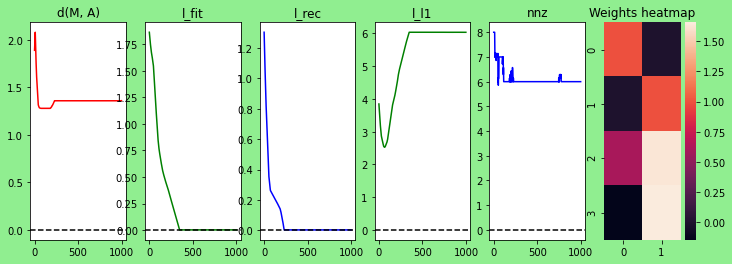

{'step.l1_coeff': 0.0774263682681127, 'step.l_rec_coeff': 10.0, 'get_results.batch_size': 128, 'repetitions': 1, 'name': 'sweep-02', '_meta': {'param_1': 'step.l_rec_coeff', 'param_2': 'step.l1_coeff'}}


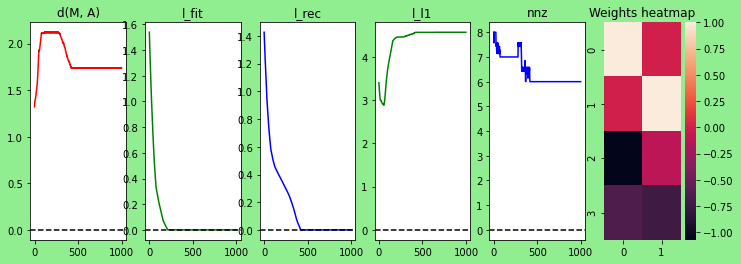

{'step.l1_coeff': 0.0774263682681127, 'step.l_rec_coeff': 10.0, 'get_results.batch_size': 128, 'repetitions': 2, 'name': 'sweep-02', '_meta': {'param_1': 'step.l_rec_coeff', 'param_2': 'step.l1_coeff'}}


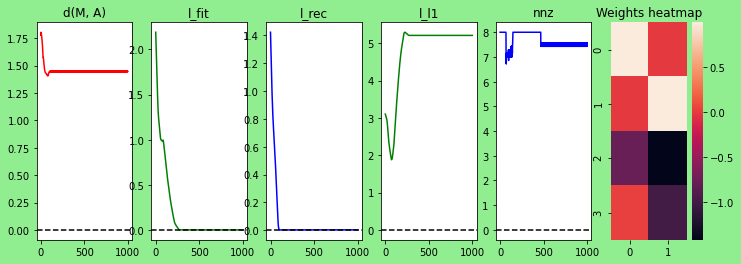

{'step.l1_coeff': 0.0774263682681127, 'step.l_rec_coeff': 10.0, 'get_results.batch_size': 128, 'repetitions': 3, 'name': 'sweep-02', '_meta': {'param_1': 'step.l_rec_coeff', 'param_2': 'step.l1_coeff'}}


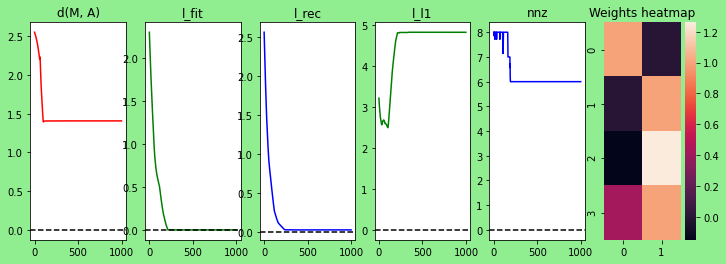

{'step.l1_coeff': 0.0774263682681127, 'step.l_rec_coeff': 10.0, 'get_results.batch_size': 128, 'repetitions': 4, 'name': 'sweep-02', '_meta': {'param_1': 'step.l_rec_coeff', 'param_2': 'step.l1_coeff'}}


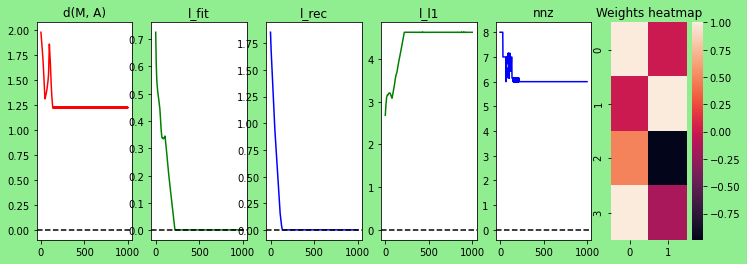

{'step.l1_coeff': 0.4641588833612782, 'step.l_rec_coeff': 1.0, 'get_results.batch_size': 128, 'repetitions': 0, 'name': 'sweep-02', '_meta': {'param_1': 'step.l_rec_coeff', 'param_2': 'step.l1_coeff'}}


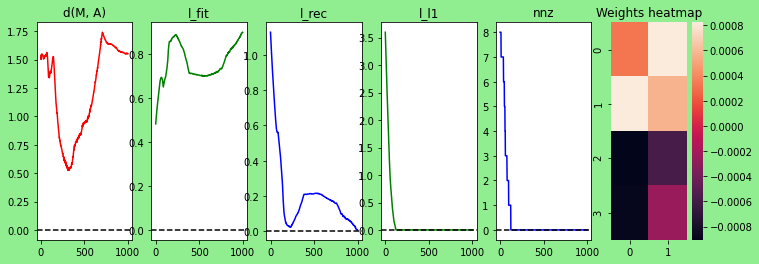

{'step.l1_coeff': 0.4641588833612782, 'step.l_rec_coeff': 1.0, 'get_results.batch_size': 128, 'repetitions': 1, 'name': 'sweep-02', '_meta': {'param_1': 'step.l_rec_coeff', 'param_2': 'step.l1_coeff'}}


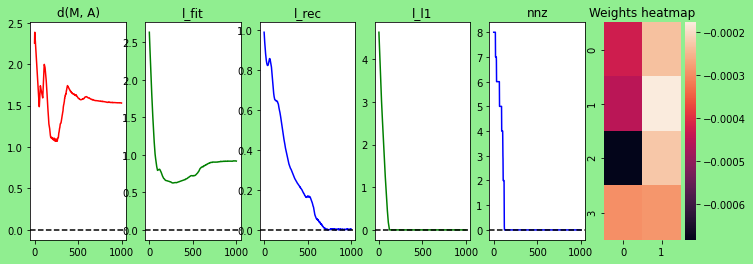

{'step.l1_coeff': 0.4641588833612782, 'step.l_rec_coeff': 1.0, 'get_results.batch_size': 128, 'repetitions': 2, 'name': 'sweep-02', '_meta': {'param_1': 'step.l_rec_coeff', 'param_2': 'step.l1_coeff'}}


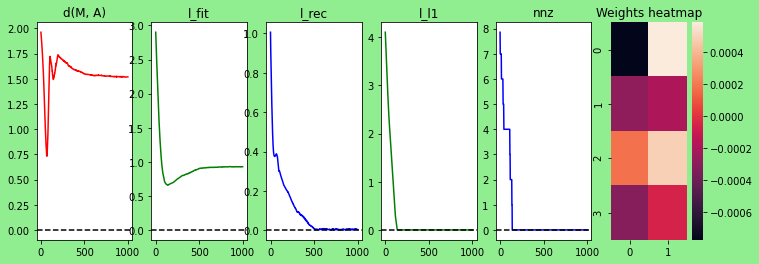

{'step.l1_coeff': 0.4641588833612782, 'step.l_rec_coeff': 1.0, 'get_results.batch_size': 128, 'repetitions': 3, 'name': 'sweep-02', '_meta': {'param_1': 'step.l_rec_coeff', 'param_2': 'step.l1_coeff'}}


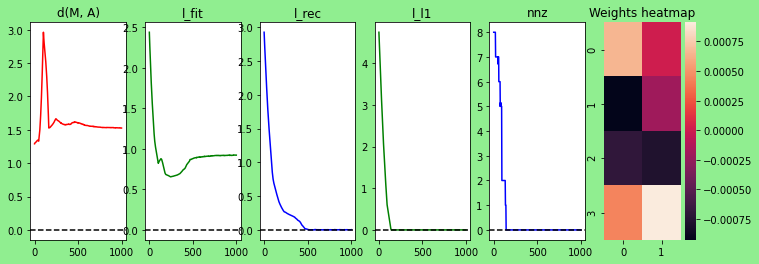

{'step.l1_coeff': 0.4641588833612782, 'step.l_rec_coeff': 1.0, 'get_results.batch_size': 128, 'repetitions': 4, 'name': 'sweep-02', '_meta': {'param_1': 'step.l_rec_coeff', 'param_2': 'step.l1_coeff'}}


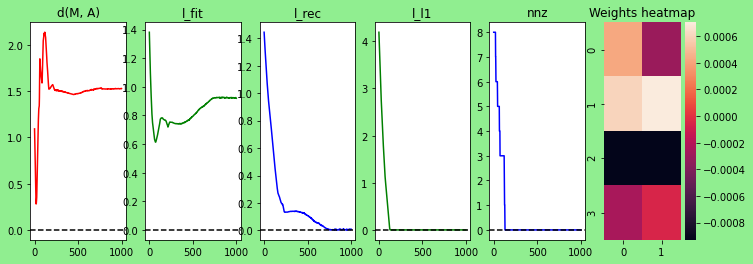

{'step.l1_coeff': 0.4641588833612782, 'step.l_rec_coeff': 3.1622776601683795, 'get_results.batch_size': 128, 'repetitions': 0, 'name': 'sweep-02', '_meta': {'param_1': 'step.l_rec_coeff', 'param_2': 'step.l1_coeff'}}


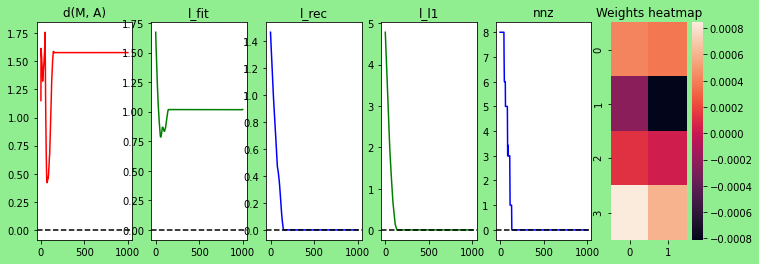

{'step.l1_coeff': 0.4641588833612782, 'step.l_rec_coeff': 3.1622776601683795, 'get_results.batch_size': 128, 'repetitions': 1, 'name': 'sweep-02', '_meta': {'param_1': 'step.l_rec_coeff', 'param_2': 'step.l1_coeff'}}


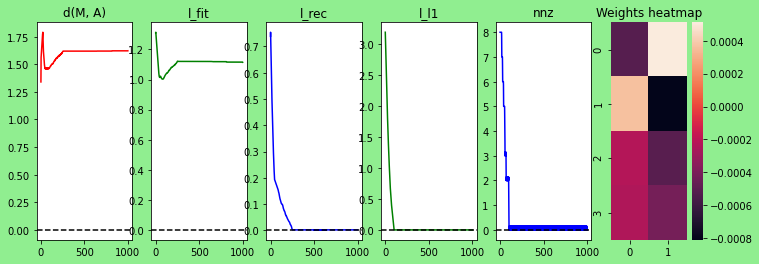

{'step.l1_coeff': 0.4641588833612782, 'step.l_rec_coeff': 3.1622776601683795, 'get_results.batch_size': 128, 'repetitions': 2, 'name': 'sweep-02', '_meta': {'param_1': 'step.l_rec_coeff', 'param_2': 'step.l1_coeff'}}


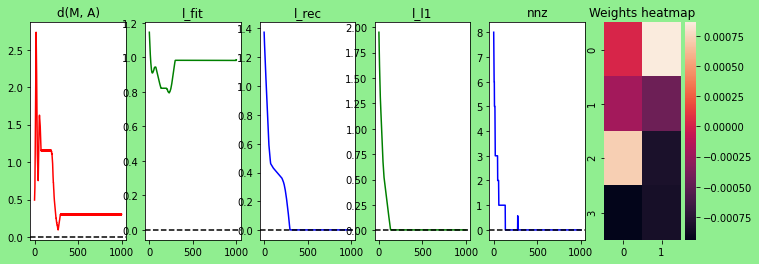

{'step.l1_coeff': 0.4641588833612782, 'step.l_rec_coeff': 3.1622776601683795, 'get_results.batch_size': 128, 'repetitions': 3, 'name': 'sweep-02', '_meta': {'param_1': 'step.l_rec_coeff', 'param_2': 'step.l1_coeff'}}


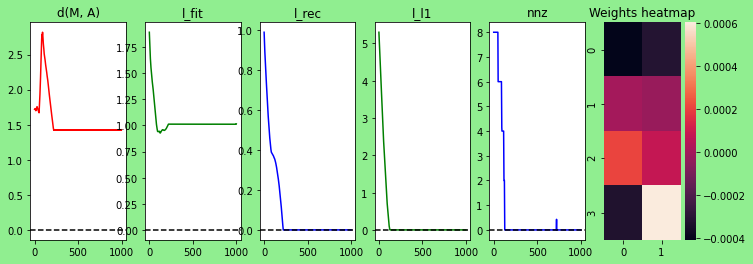

{'step.l1_coeff': 0.4641588833612782, 'step.l_rec_coeff': 3.1622776601683795, 'get_results.batch_size': 128, 'repetitions': 4, 'name': 'sweep-02', '_meta': {'param_1': 'step.l_rec_coeff', 'param_2': 'step.l1_coeff'}}


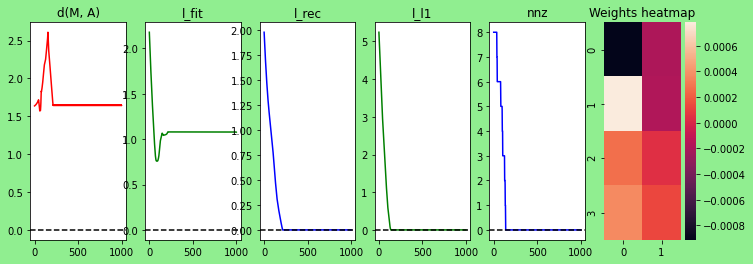

{'step.l1_coeff': 0.4641588833612782, 'step.l_rec_coeff': 10.0, 'get_results.batch_size': 128, 'repetitions': 0, 'name': 'sweep-02', '_meta': {'param_1': 'step.l_rec_coeff', 'param_2': 'step.l1_coeff'}}


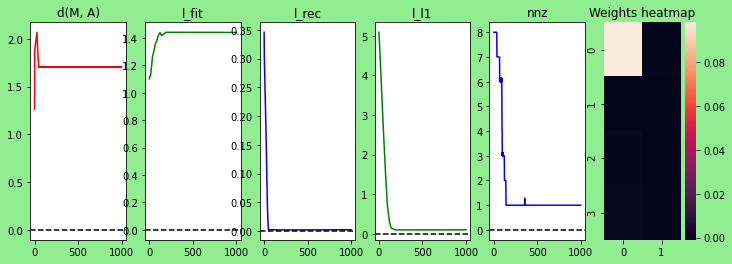

{'step.l1_coeff': 0.4641588833612782, 'step.l_rec_coeff': 10.0, 'get_results.batch_size': 128, 'repetitions': 1, 'name': 'sweep-02', '_meta': {'param_1': 'step.l_rec_coeff', 'param_2': 'step.l1_coeff'}}


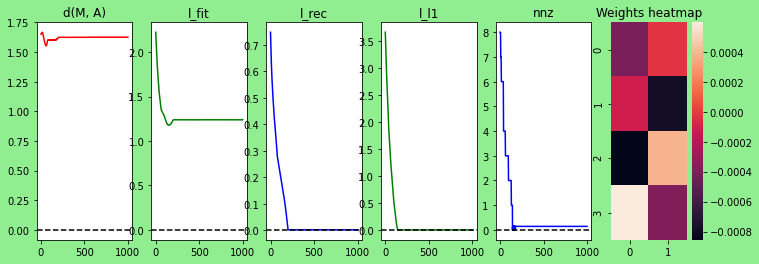

{'step.l1_coeff': 0.4641588833612782, 'step.l_rec_coeff': 10.0, 'get_results.batch_size': 128, 'repetitions': 2, 'name': 'sweep-02', '_meta': {'param_1': 'step.l_rec_coeff', 'param_2': 'step.l1_coeff'}}


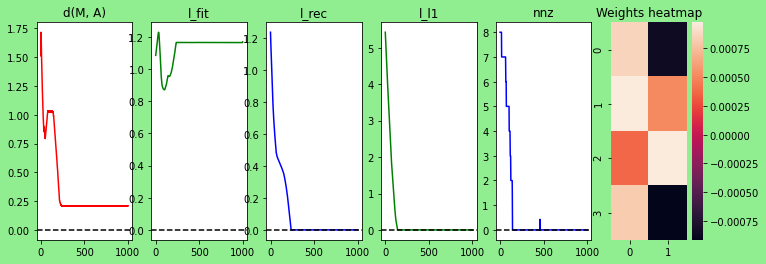

{'step.l1_coeff': 0.4641588833612782, 'step.l_rec_coeff': 10.0, 'get_results.batch_size': 128, 'repetitions': 3, 'name': 'sweep-02', '_meta': {'param_1': 'step.l_rec_coeff', 'param_2': 'step.l1_coeff'}}


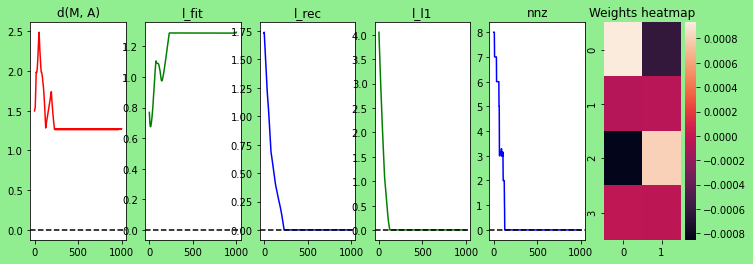

{'step.l1_coeff': 0.4641588833612782, 'step.l_rec_coeff': 10.0, 'get_results.batch_size': 128, 'repetitions': 4, 'name': 'sweep-02', '_meta': {'param_1': 'step.l_rec_coeff', 'param_2': 'step.l1_coeff'}}


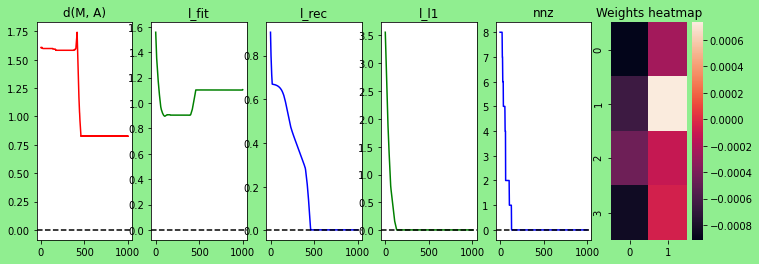

{'step.l1_coeff': 2.782559402207126, 'step.l_rec_coeff': 1.0, 'get_results.batch_size': 128, 'repetitions': 0, 'name': 'sweep-02', '_meta': {'param_1': 'step.l_rec_coeff', 'param_2': 'step.l1_coeff'}}


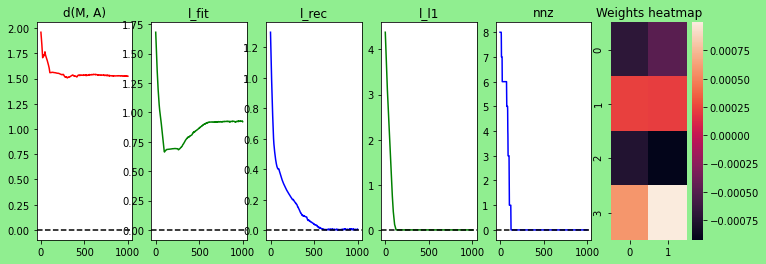

{'step.l1_coeff': 2.782559402207126, 'step.l_rec_coeff': 1.0, 'get_results.batch_size': 128, 'repetitions': 1, 'name': 'sweep-02', '_meta': {'param_1': 'step.l_rec_coeff', 'param_2': 'step.l1_coeff'}}


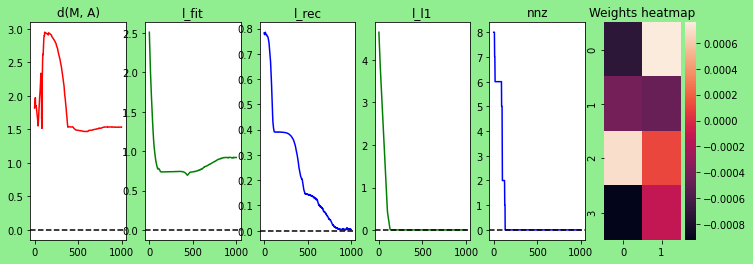

{'step.l1_coeff': 2.782559402207126, 'step.l_rec_coeff': 1.0, 'get_results.batch_size': 128, 'repetitions': 2, 'name': 'sweep-02', '_meta': {'param_1': 'step.l_rec_coeff', 'param_2': 'step.l1_coeff'}}


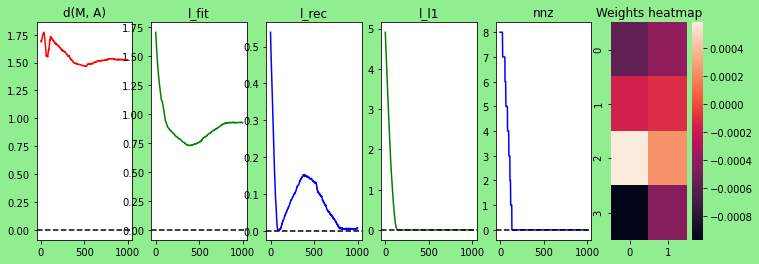

{'step.l1_coeff': 2.782559402207126, 'step.l_rec_coeff': 1.0, 'get_results.batch_size': 128, 'repetitions': 3, 'name': 'sweep-02', '_meta': {'param_1': 'step.l_rec_coeff', 'param_2': 'step.l1_coeff'}}


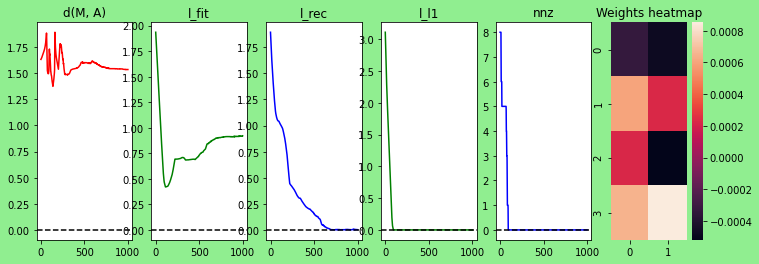

{'step.l1_coeff': 2.782559402207126, 'step.l_rec_coeff': 1.0, 'get_results.batch_size': 128, 'repetitions': 4, 'name': 'sweep-02', '_meta': {'param_1': 'step.l_rec_coeff', 'param_2': 'step.l1_coeff'}}


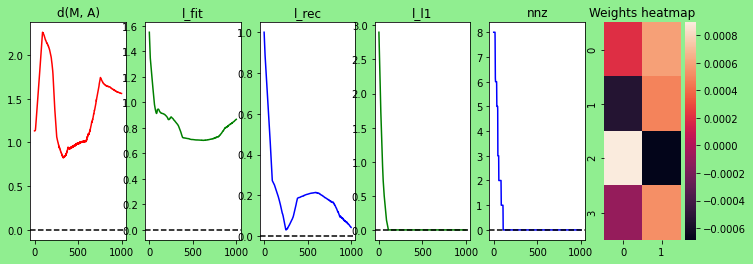

{'step.l1_coeff': 2.782559402207126, 'step.l_rec_coeff': 3.1622776601683795, 'get_results.batch_size': 128, 'repetitions': 0, 'name': 'sweep-02', '_meta': {'param_1': 'step.l_rec_coeff', 'param_2': 'step.l1_coeff'}}


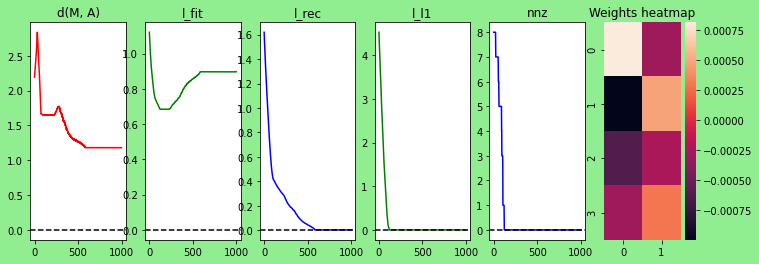

{'step.l1_coeff': 2.782559402207126, 'step.l_rec_coeff': 3.1622776601683795, 'get_results.batch_size': 128, 'repetitions': 1, 'name': 'sweep-02', '_meta': {'param_1': 'step.l_rec_coeff', 'param_2': 'step.l1_coeff'}}


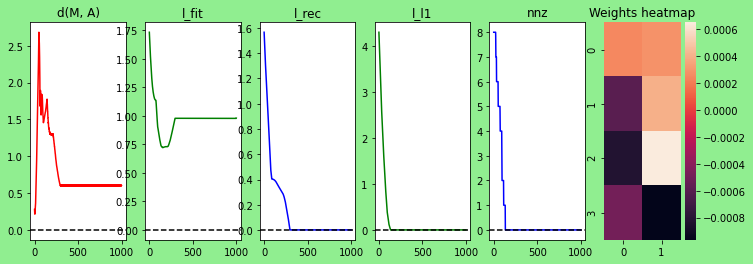

{'step.l1_coeff': 2.782559402207126, 'step.l_rec_coeff': 3.1622776601683795, 'get_results.batch_size': 128, 'repetitions': 2, 'name': 'sweep-02', '_meta': {'param_1': 'step.l_rec_coeff', 'param_2': 'step.l1_coeff'}}


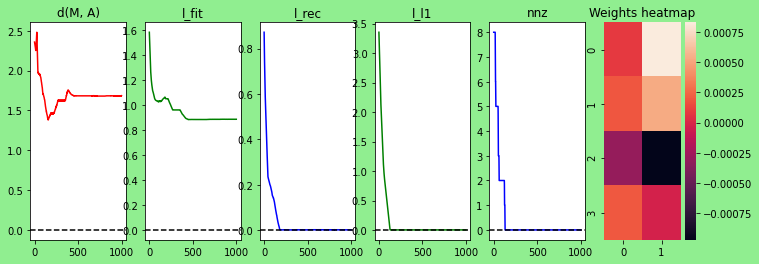

{'step.l1_coeff': 2.782559402207126, 'step.l_rec_coeff': 3.1622776601683795, 'get_results.batch_size': 128, 'repetitions': 3, 'name': 'sweep-02', '_meta': {'param_1': 'step.l_rec_coeff', 'param_2': 'step.l1_coeff'}}


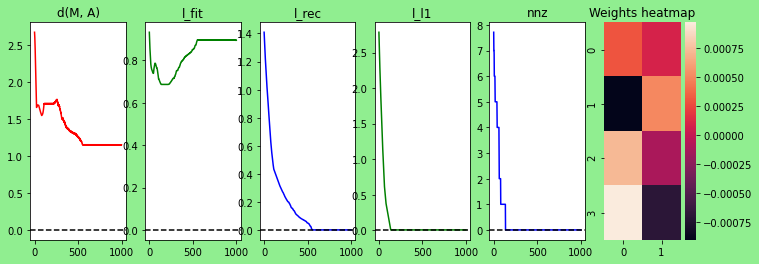

{'step.l1_coeff': 2.782559402207126, 'step.l_rec_coeff': 3.1622776601683795, 'get_results.batch_size': 128, 'repetitions': 4, 'name': 'sweep-02', '_meta': {'param_1': 'step.l_rec_coeff', 'param_2': 'step.l1_coeff'}}


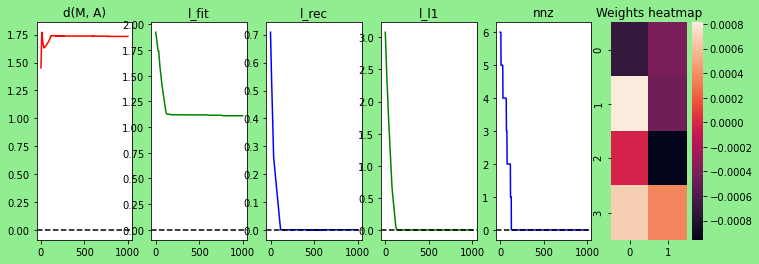

{'step.l1_coeff': 2.782559402207126, 'step.l_rec_coeff': 10.0, 'get_results.batch_size': 128, 'repetitions': 0, 'name': 'sweep-02', '_meta': {'param_1': 'step.l_rec_coeff', 'param_2': 'step.l1_coeff'}}


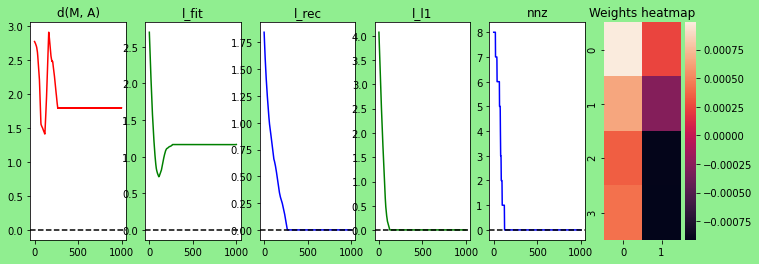

{'step.l1_coeff': 2.782559402207126, 'step.l_rec_coeff': 10.0, 'get_results.batch_size': 128, 'repetitions': 1, 'name': 'sweep-02', '_meta': {'param_1': 'step.l_rec_coeff', 'param_2': 'step.l1_coeff'}}


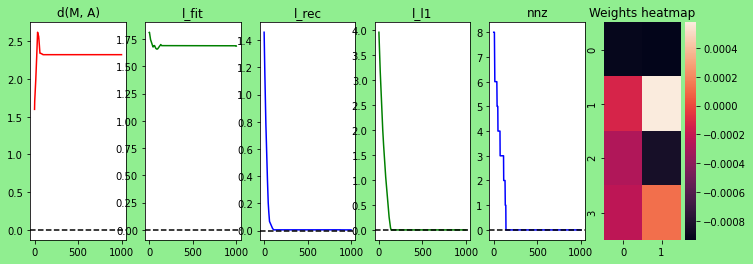

{'step.l1_coeff': 2.782559402207126, 'step.l_rec_coeff': 10.0, 'get_results.batch_size': 128, 'repetitions': 2, 'name': 'sweep-02', '_meta': {'param_1': 'step.l_rec_coeff', 'param_2': 'step.l1_coeff'}}


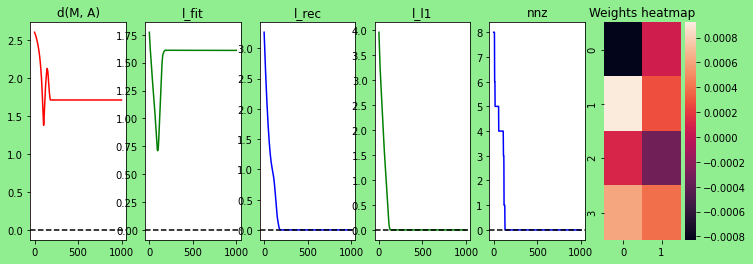

{'step.l1_coeff': 2.782559402207126, 'step.l_rec_coeff': 10.0, 'get_results.batch_size': 128, 'repetitions': 3, 'name': 'sweep-02', '_meta': {'param_1': 'step.l_rec_coeff', 'param_2': 'step.l1_coeff'}}


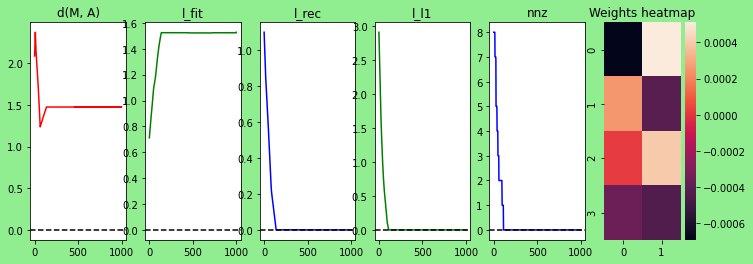

{'step.l1_coeff': 2.782559402207126, 'step.l_rec_coeff': 10.0, 'get_results.batch_size': 128, 'repetitions': 4, 'name': 'sweep-02', '_meta': {'param_1': 'step.l_rec_coeff', 'param_2': 'step.l1_coeff'}}


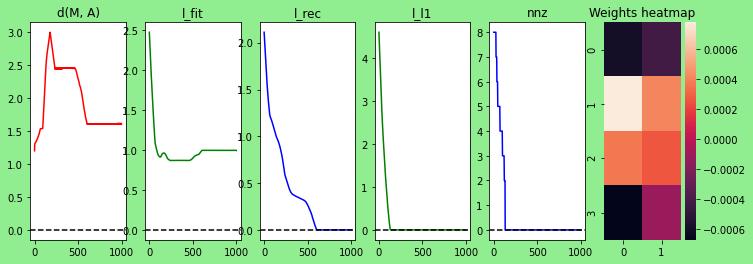

{'step.l1_coeff': 16.68100537200059, 'step.l_rec_coeff': 1.0, 'get_results.batch_size': 128, 'repetitions': 0, 'name': 'sweep-02', '_meta': {'param_1': 'step.l_rec_coeff', 'param_2': 'step.l1_coeff'}}


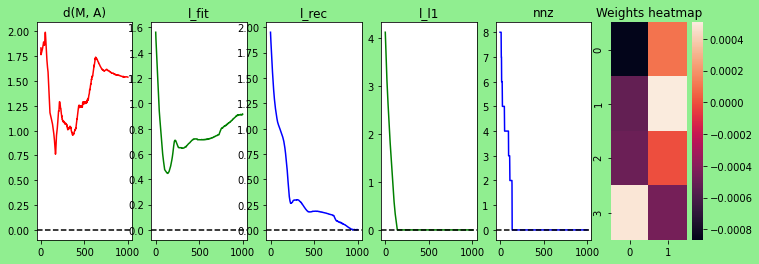

{'step.l1_coeff': 16.68100537200059, 'step.l_rec_coeff': 1.0, 'get_results.batch_size': 128, 'repetitions': 1, 'name': 'sweep-02', '_meta': {'param_1': 'step.l_rec_coeff', 'param_2': 'step.l1_coeff'}}


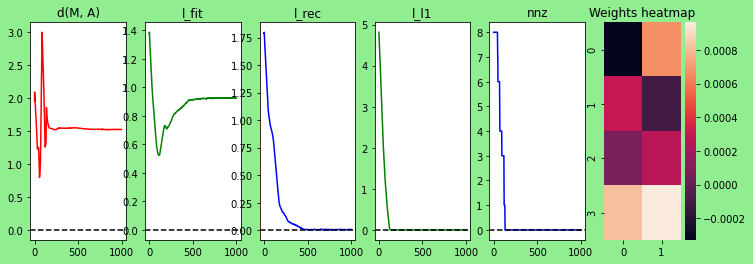

{'step.l1_coeff': 16.68100537200059, 'step.l_rec_coeff': 1.0, 'get_results.batch_size': 128, 'repetitions': 2, 'name': 'sweep-02', '_meta': {'param_1': 'step.l_rec_coeff', 'param_2': 'step.l1_coeff'}}


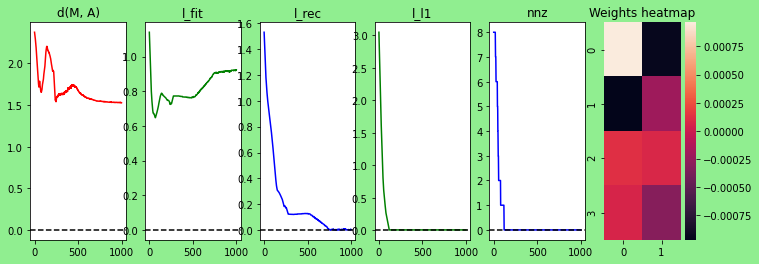

{'step.l1_coeff': 16.68100537200059, 'step.l_rec_coeff': 1.0, 'get_results.batch_size': 128, 'repetitions': 3, 'name': 'sweep-02', '_meta': {'param_1': 'step.l_rec_coeff', 'param_2': 'step.l1_coeff'}}


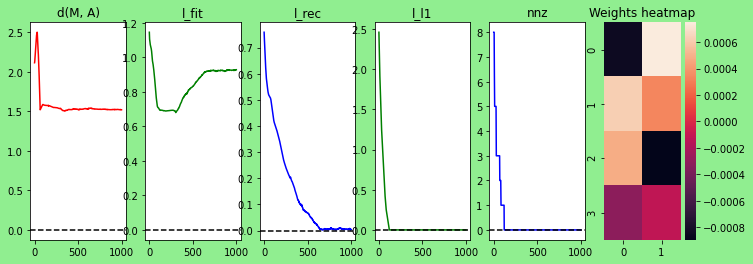

{'step.l1_coeff': 16.68100537200059, 'step.l_rec_coeff': 1.0, 'get_results.batch_size': 128, 'repetitions': 4, 'name': 'sweep-02', '_meta': {'param_1': 'step.l_rec_coeff', 'param_2': 'step.l1_coeff'}}


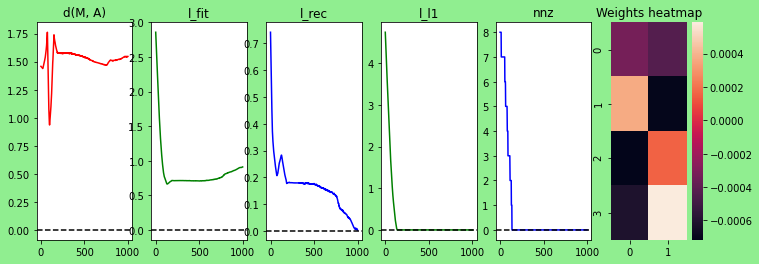

{'step.l1_coeff': 16.68100537200059, 'step.l_rec_coeff': 3.1622776601683795, 'get_results.batch_size': 128, 'repetitions': 0, 'name': 'sweep-02', '_meta': {'param_1': 'step.l_rec_coeff', 'param_2': 'step.l1_coeff'}}


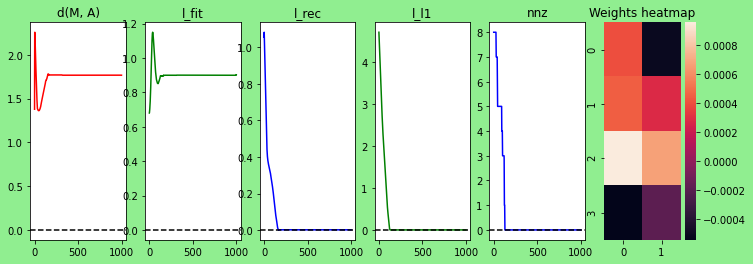

{'step.l1_coeff': 16.68100537200059, 'step.l_rec_coeff': 3.1622776601683795, 'get_results.batch_size': 128, 'repetitions': 1, 'name': 'sweep-02', '_meta': {'param_1': 'step.l_rec_coeff', 'param_2': 'step.l1_coeff'}}


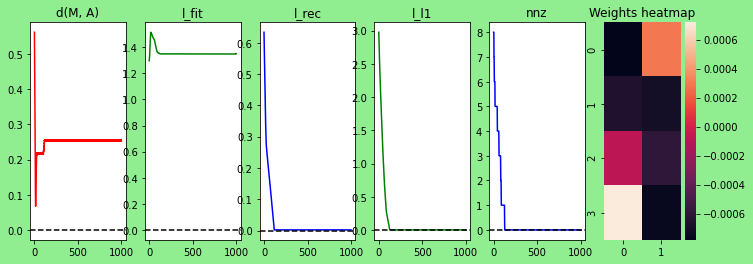

{'step.l1_coeff': 16.68100537200059, 'step.l_rec_coeff': 3.1622776601683795, 'get_results.batch_size': 128, 'repetitions': 2, 'name': 'sweep-02', '_meta': {'param_1': 'step.l_rec_coeff', 'param_2': 'step.l1_coeff'}}


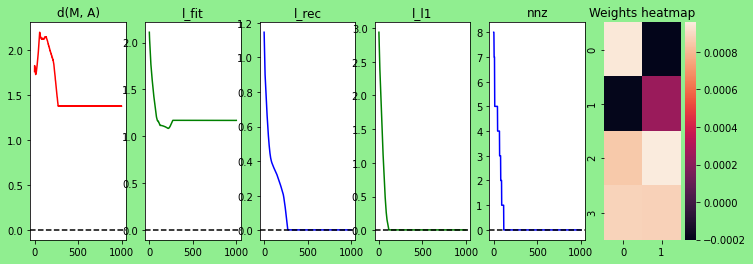

{'step.l1_coeff': 16.68100537200059, 'step.l_rec_coeff': 3.1622776601683795, 'get_results.batch_size': 128, 'repetitions': 3, 'name': 'sweep-02', '_meta': {'param_1': 'step.l_rec_coeff', 'param_2': 'step.l1_coeff'}}


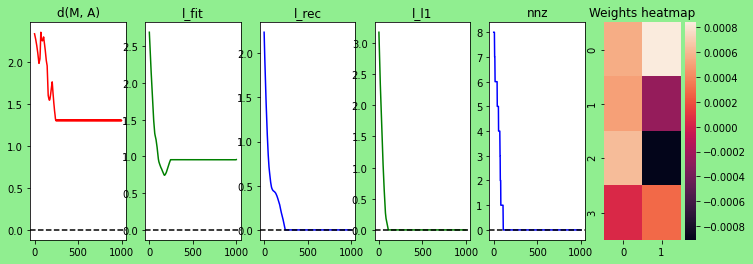

{'step.l1_coeff': 16.68100537200059, 'step.l_rec_coeff': 3.1622776601683795, 'get_results.batch_size': 128, 'repetitions': 4, 'name': 'sweep-02', '_meta': {'param_1': 'step.l_rec_coeff', 'param_2': 'step.l1_coeff'}}


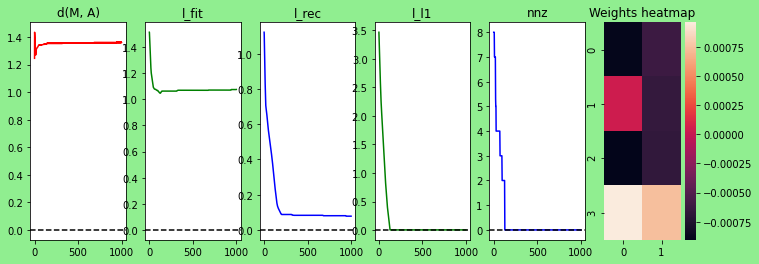

{'step.l1_coeff': 16.68100537200059, 'step.l_rec_coeff': 10.0, 'get_results.batch_size': 128, 'repetitions': 0, 'name': 'sweep-02', '_meta': {'param_1': 'step.l_rec_coeff', 'param_2': 'step.l1_coeff'}}


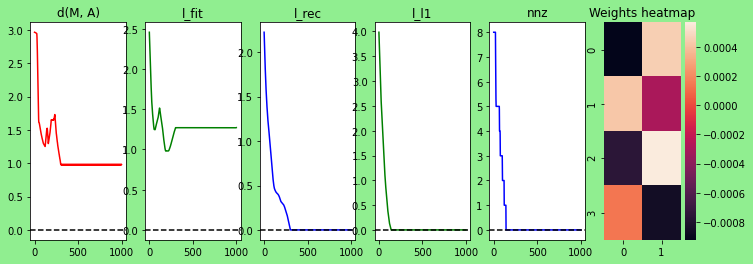

{'step.l1_coeff': 16.68100537200059, 'step.l_rec_coeff': 10.0, 'get_results.batch_size': 128, 'repetitions': 1, 'name': 'sweep-02', '_meta': {'param_1': 'step.l_rec_coeff', 'param_2': 'step.l1_coeff'}}


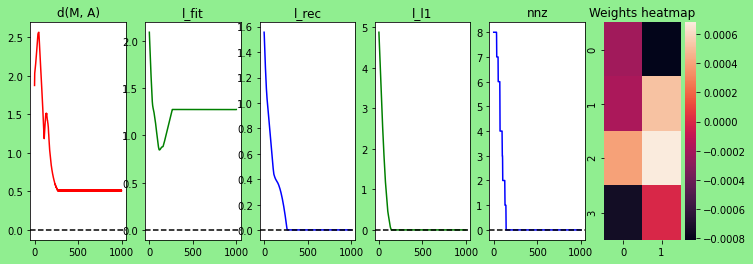

{'step.l1_coeff': 16.68100537200059, 'step.l_rec_coeff': 10.0, 'get_results.batch_size': 128, 'repetitions': 2, 'name': 'sweep-02', '_meta': {'param_1': 'step.l_rec_coeff', 'param_2': 'step.l1_coeff'}}


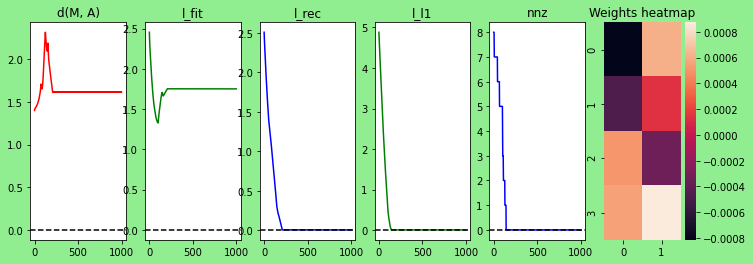

{'step.l1_coeff': 16.68100537200059, 'step.l_rec_coeff': 10.0, 'get_results.batch_size': 128, 'repetitions': 3, 'name': 'sweep-02', '_meta': {'param_1': 'step.l_rec_coeff', 'param_2': 'step.l1_coeff'}}


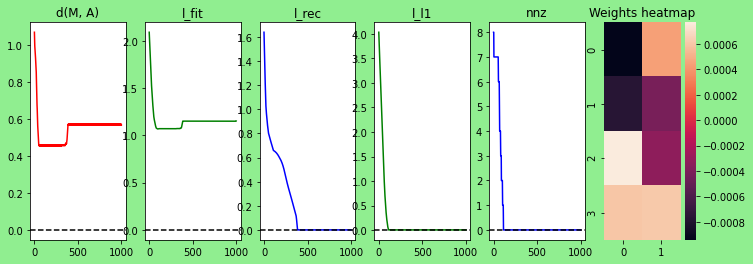

{'step.l1_coeff': 16.68100537200059, 'step.l_rec_coeff': 10.0, 'get_results.batch_size': 128, 'repetitions': 4, 'name': 'sweep-02', '_meta': {'param_1': 'step.l_rec_coeff', 'param_2': 'step.l1_coeff'}}


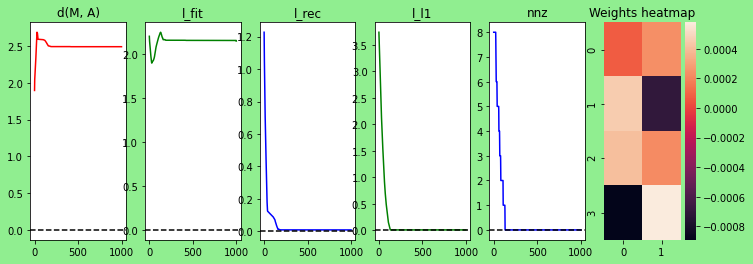

{'step.l1_coeff': 100.0, 'step.l_rec_coeff': 1.0, 'get_results.batch_size': 128, 'repetitions': 0, 'name': 'sweep-02', '_meta': {'param_1': 'step.l_rec_coeff', 'param_2': 'step.l1_coeff'}}


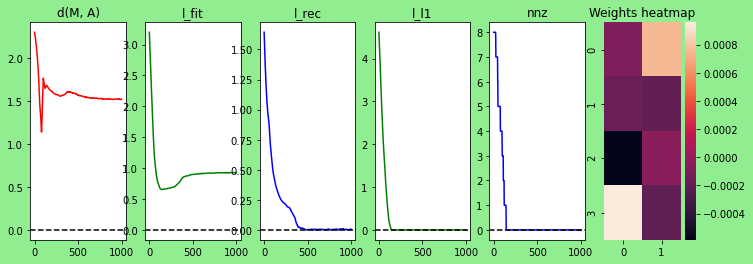

{'step.l1_coeff': 100.0, 'step.l_rec_coeff': 1.0, 'get_results.batch_size': 128, 'repetitions': 1, 'name': 'sweep-02', '_meta': {'param_1': 'step.l_rec_coeff', 'param_2': 'step.l1_coeff'}}


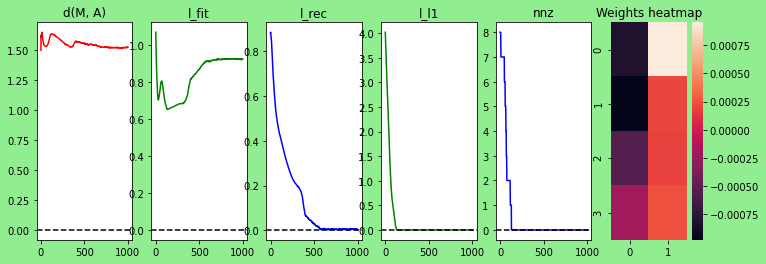

{'step.l1_coeff': 100.0, 'step.l_rec_coeff': 1.0, 'get_results.batch_size': 128, 'repetitions': 2, 'name': 'sweep-02', '_meta': {'param_1': 'step.l_rec_coeff', 'param_2': 'step.l1_coeff'}}


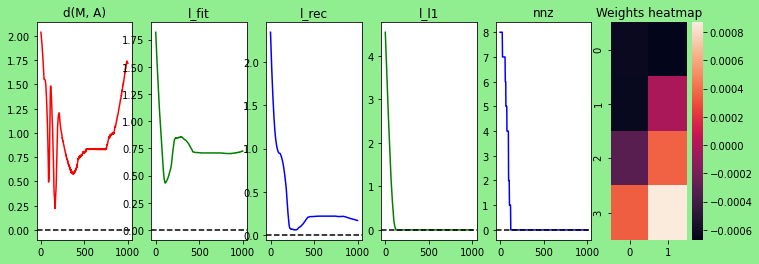

{'step.l1_coeff': 100.0, 'step.l_rec_coeff': 1.0, 'get_results.batch_size': 128, 'repetitions': 3, 'name': 'sweep-02', '_meta': {'param_1': 'step.l_rec_coeff', 'param_2': 'step.l1_coeff'}}


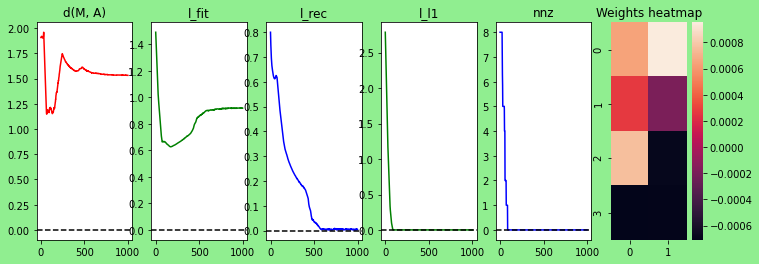

{'step.l1_coeff': 100.0, 'step.l_rec_coeff': 1.0, 'get_results.batch_size': 128, 'repetitions': 4, 'name': 'sweep-02', '_meta': {'param_1': 'step.l_rec_coeff', 'param_2': 'step.l1_coeff'}}


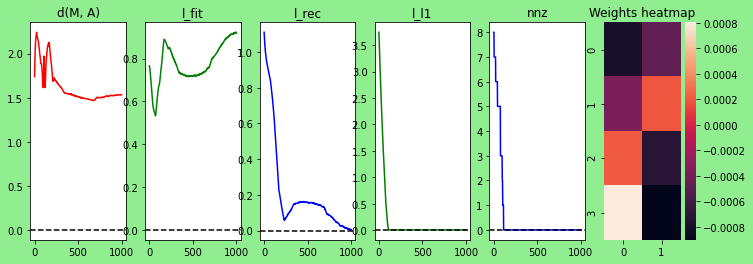

{'step.l1_coeff': 100.0, 'step.l_rec_coeff': 3.1622776601683795, 'get_results.batch_size': 128, 'repetitions': 0, 'name': 'sweep-02', '_meta': {'param_1': 'step.l_rec_coeff', 'param_2': 'step.l1_coeff'}}


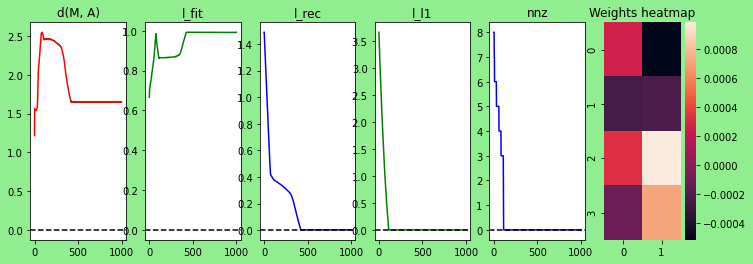

{'step.l1_coeff': 100.0, 'step.l_rec_coeff': 3.1622776601683795, 'get_results.batch_size': 128, 'repetitions': 1, 'name': 'sweep-02', '_meta': {'param_1': 'step.l_rec_coeff', 'param_2': 'step.l1_coeff'}}


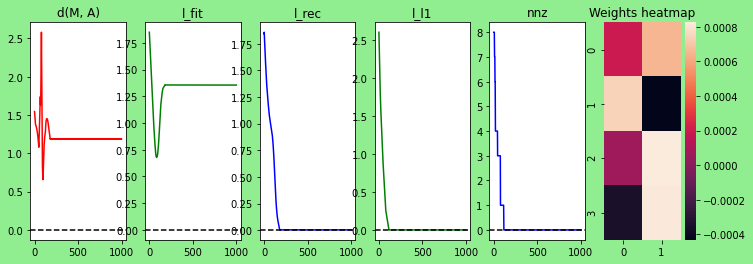

{'step.l1_coeff': 100.0, 'step.l_rec_coeff': 3.1622776601683795, 'get_results.batch_size': 128, 'repetitions': 2, 'name': 'sweep-02', '_meta': {'param_1': 'step.l_rec_coeff', 'param_2': 'step.l1_coeff'}}


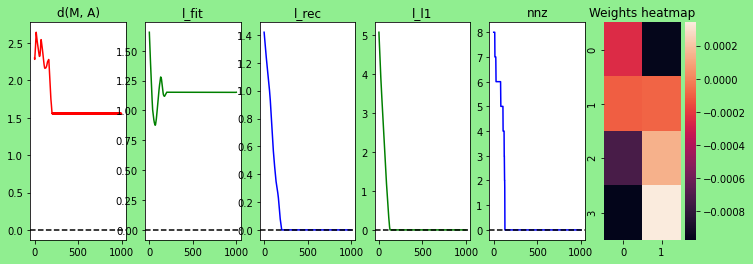

{'step.l1_coeff': 100.0, 'step.l_rec_coeff': 3.1622776601683795, 'get_results.batch_size': 128, 'repetitions': 3, 'name': 'sweep-02', '_meta': {'param_1': 'step.l_rec_coeff', 'param_2': 'step.l1_coeff'}}


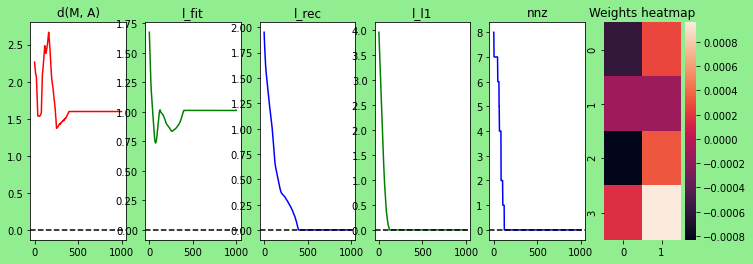

{'step.l1_coeff': 100.0, 'step.l_rec_coeff': 3.1622776601683795, 'get_results.batch_size': 128, 'repetitions': 4, 'name': 'sweep-02', '_meta': {'param_1': 'step.l_rec_coeff', 'param_2': 'step.l1_coeff'}}


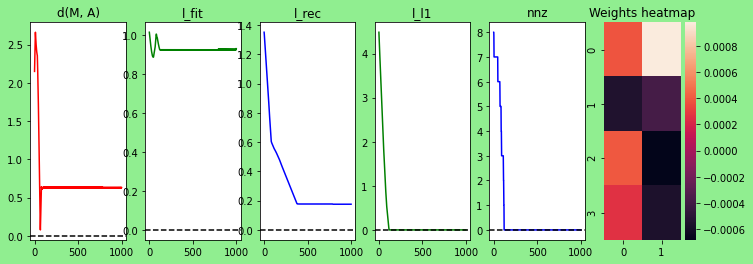

{'step.l1_coeff': 100.0, 'step.l_rec_coeff': 10.0, 'get_results.batch_size': 128, 'repetitions': 0, 'name': 'sweep-02', '_meta': {'param_1': 'step.l_rec_coeff', 'param_2': 'step.l1_coeff'}}


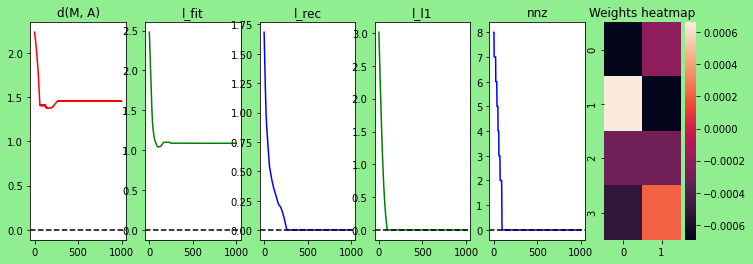

{'step.l1_coeff': 100.0, 'step.l_rec_coeff': 10.0, 'get_results.batch_size': 128, 'repetitions': 1, 'name': 'sweep-02', '_meta': {'param_1': 'step.l_rec_coeff', 'param_2': 'step.l1_coeff'}}


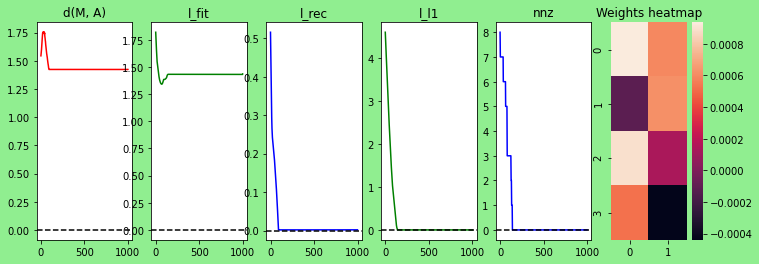

{'step.l1_coeff': 100.0, 'step.l_rec_coeff': 10.0, 'get_results.batch_size': 128, 'repetitions': 2, 'name': 'sweep-02', '_meta': {'param_1': 'step.l_rec_coeff', 'param_2': 'step.l1_coeff'}}


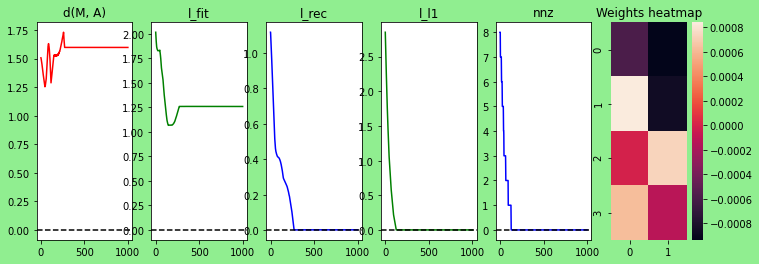

{'step.l1_coeff': 100.0, 'step.l_rec_coeff': 10.0, 'get_results.batch_size': 128, 'repetitions': 3, 'name': 'sweep-02', '_meta': {'param_1': 'step.l_rec_coeff', 'param_2': 'step.l1_coeff'}}


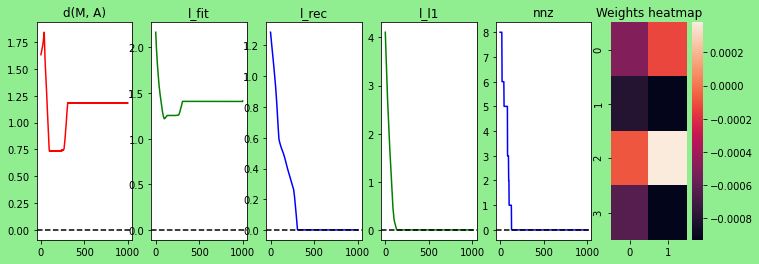

{'step.l1_coeff': 100.0, 'step.l_rec_coeff': 10.0, 'get_results.batch_size': 128, 'repetitions': 4, 'name': 'sweep-02', '_meta': {'param_1': 'step.l_rec_coeff', 'param_2': 'step.l1_coeff'}}


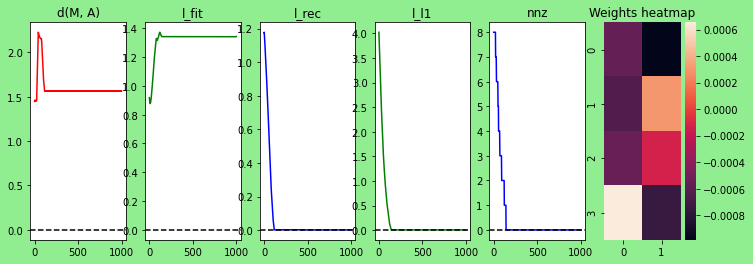

In [9]:
# show all results
for p, r in zip(all_params, results):
    process_results(r, str(p))

In [10]:
def quality_metric_last_l_fit(res):
    """Scalar quality metric: last fit loss."""
    #print(res)
    return res[1][0]['l_fit'][-1]

quality_metric_last_l_fit.title = "l_fit"

def quality_metric_last_l_rec(res):
    """Scalar quality metric: last rec loss."""
    #print(res)
    return res[1][0]['l_rec'][-1]

quality_metric_last_l_rec.title = "l_rec"

def quality_metric_last_l_l1(res):
    """Scalar quality metric: last rec loss."""
    #print(res)
    return res[1][0]['l_l1'][-1]

quality_metric_last_l_l1.title = "l_l1"

def quality_metric_last_de(res):
    """Scalar quality metric: last rec loss."""
    #print(res)
    return res[1][1][-1]

quality_metric_last_de.title = "de"

def quality_metric_combined(res):
    """Combined metric."""
    return max(quality_metric_last_l_fit(res), quality_metric_last_l_rec(res))
quality_metric_combined.title = "combined"

In [11]:
def plot_3d(metric):
    """Plot a metric in 3d."""
    # preparing data for the 3d plot
    X, Y, Z = [], [], []
    Xm, Ym, Zm = [], [], []
    Pm = []

    for p1 in sweep[param_1]:
        for p2 in sweep[param_2]:
            R = filter_results(**{param_1: p1, param_2: p2})
            for r in R:
                X.append(p1)
                Y.append(p2)
                Z.append(metric(r))
            Xm.append(p1)
            Ym.append(p2)
            Zm.append(np.median([metric(r) for r in R]))
            Pm.append((p1, p2))

    # Doing 3d plot

    # Configure the trace.
    trace1 = go.Mesh3d(x=Xm, y=Ym, z=Zm, opacity=0.5)

    # Configure the trace.
    trace2 = go.Scatter3d(x=X, y=Y, z=Z, opacity=0.5, mode='markers',
        marker={'size': 10, 'opacity': 0.8}
    )

    # Configure the layout.
    layout = go.Layout(
        margin={'l': 0, 'r': 0, 'b': 0, 't': 0}
    )

    data = [trace1, trace2]

    plot_figure = go.Figure(data=data, layout=layout)

    plot_figure.update_layout(scene = dict(xaxis_title=param_1,
                        yaxis_title=param_2,
                        zaxis_title=metric.title,
                        xaxis_type="log", yaxis_type="log"),
                        width=700,
                        margin=dict(r=20, b=10, l=10, t=10))


    # Render the plot.
    plotly.offline.iplot(plot_figure)
    
    return Zm, Pm

In [12]:
# l1rec now working??? well, yeah I use a custom training procedure...
Zm, Pm = plot_3d(quality_metric_combined)

In [13]:
# l1rec now working??? well, yeah I use a custom training procedure...
Zm, Pm = plot_3d(quality_metric_last_l_l1)

In [14]:
# l1rec now working??? well, yeah I use a custom training procedure...
Zm, Pm = plot_3d(quality_metric_last_de)

In [15]:
idx = np.argmin(Zm)
P = Pm[idx]
print("%s=%.2f, %s=%.2f metric=%.2f" % (param_1, P[0], param_2, P[1], Zm[idx]))

step.l_rec_coeff=3.16, step.l1_coeff=0.08 metric=0.97


In [16]:
# best parameters
best_param_idx = all_params.index(filter_results(**{param_1: P[0], param_2: P[1]})[0][0])
best_param = all_params[best_param_idx]

# RESULTS

`sweep_00`: best hyperparams l_rec_coeff=1, batch_size=256
`sweep_01`: works OK if bs <= 200 and l_re >= 1

# Manual computation

In [17]:
import tensorflow as tf
tf.compat.v1.enable_v2_behavior()
import synthetic_experiment

1000/1000 [==============================] - 0s 41us/sample - loss: 1.0308e-05
1.0308363518561236e-05
[<tf.Variable 'sequential/dense/kernel:0' shape=(4, 2) dtype=float32, numpy=
array([[ 9.9961758e-01, -1.1106259e-04],
       [-9.6209813e-05,  9.9562424e-01],
       [ 9.9897975e-01, -3.7962111e-04],
       [-3.9590122e-05,  9.9994129e-01]], dtype=float32)>, <tf.Variable 'sequential/dense/bias:0' shape=(2,) dtype=float32, numpy=array([ 5.541716e-05, -1.737795e-04], dtype=float32)>]
0.0064636261013220064


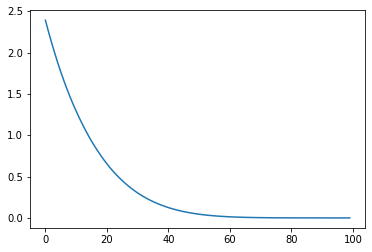

In [18]:
synthetic_experiment.fit_test_model(xs, ys, A)

In [19]:
# best_param = all_params[0]
set_params(best_param, synthetic_experiment)
best_param

{'step.l1_coeff': 0.0774263682681127,
 'step.l_rec_coeff': 3.1622776601683795,
 'get_results.batch_size': 128,
 'repetitions': 0,
 'name': 'sweep-02',
 '_meta': {'param_1': 'step.l_rec_coeff', 'param_2': 'step.l1_coeff'}}

In [20]:
# getting results manually
res = synthetic_experiment.get_results(xs_e, ys_e, Q1)

best


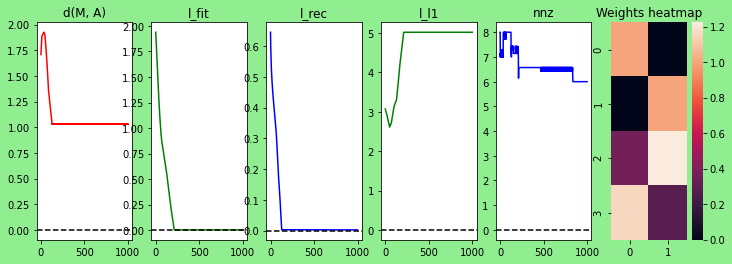

In [21]:
process_results(res, "best")

In [22]:
pickle.dump(results, open('results_%s.pkl' % sweep['name'][0], 'wb'))